# Import Library

In [86]:
import numpy as np
import pandas as pd  
import math
import time
import warnings
import polars as pl
import re
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Import CSV file

In [87]:
path = 'extractedLabResult.csv'
lab_df = pd.read_csv(path)

In [88]:
lab_df

,rowID,cid,labItemsNameRef,labItemsNormalValueRef,labOrderResult,labItemsUnit
0,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,HCT,37 - 47,36.4,%
1,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,WBC,4.00 - 10.00,20.0,NaN
2,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,RBC,0-5,4.62,NaN
3,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,PLT,140 - 400,479,NaN
4,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,Neutrophil,60 - 75,88.7,%
...,...,...,...,...,...,...
5251,1845430,15485864aca2d753ef1e4f1db274ea670e9e317d8f9a63...,Urine Color,NaN,Yellow,NaN
5252,1845430,15485864aca2d753ef1e4f1db274ea670e9e317d8f9a63...,Urine pH,5.0 - 8.0,6.5,NaN
5253,1845430,15485864aca2d753ef1e4f1db274ea670e9e317d8f9a63...,Urine Sugar,NaN,Trace,NaN
5254,1845430,15485864aca2d753ef1e4f1db274ea670e9e317d8f9a63...,Urine RBC,0 - 5,Negative,NaN


In [89]:
lab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5256 entries, 0 to 5255
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   rowID                   5256 non-null   int64 
 1   cid                     5256 non-null   object
 2   labItemsNameRef         5256 non-null   object
 3   labItemsNormalValueRef  4494 non-null   object
 4   labOrderResult          5240 non-null   object
 5   labItemsUnit            1681 non-null   object
dtypes: int64(1), object(5)
memory usage: 246.5+ KB


In [90]:
lab_df.isna().sum()

rowID                        0
cid                          0
labItemsNameRef              0
labItemsNormalValueRef     762
labOrderResult              16
labItemsUnit              3575
dtype: int64

In [91]:
lab_df['labItemsNameRef'].unique()

array(['HCT', 'WBC', 'RBC', 'PLT', 'Neutrophil', 'Lymphocytes', 'MCV',
       'MCH', 'MCHC', 'BUN', 'Creatinine', 'Leukocytes', 'Bacteria',
       'Urine Albumin', 'Urine Bilirubin', 'Urine Ketone', 'Urine RBC',
       'Urine WBC', 'Urine Color', 'Urine pH', 'Urine Sugar'],
      dtype=object)

In [92]:
lab_df['labItemsNormalValueRef'].unique()

array(['37 - 47', '4.00 - 10.00', '0-5', '140 - 400', '60 - 75',
       '25 - 40', '80.00 - 100.00', '28.0 - 32.0', '32.0 - 36.0',
       '9.00 - 20.00', '0.52 - 1.04', 'Negative', nan, '0 - 5',
       '5.0 - 8.0'], dtype=object)

In [93]:
lab_df['labOrderResult'].unique()

array(['36.4', '20.0', '4.62', ..., '7.55', '76.5', '72.5'], dtype=object)

In [94]:
lab_df['labItemsUnit'].unique()

array([' %', nan, ' fl', ' pg', ' mg/dL'], dtype=object)

In [95]:
lab_names = list(lab_df['labItemsNameRef'].unique())
lab_names

['HCT',
 'WBC',
 'RBC',
 'PLT',
 'Neutrophil',
 'Lymphocytes',
 'MCV',
 'MCH',
 'MCHC',
 'BUN',
 'Creatinine',
 'Leukocytes',
 'Bacteria',
 'Urine Albumin',
 'Urine Bilirubin',
 'Urine Ketone',
 'Urine RBC',
 'Urine WBC',
 'Urine Color',
 'Urine pH',
 'Urine Sugar']

# EDA

## 1. Normal Distribution

Obj: 

In [96]:
%%time
# for lab in lab_names:
#     df1 = lab_df.loc[lab_df['labItemsNameRef'] == lab].sort_values(by=['labOrderResult'])
#     title = '%s %s %d'%(lab,df1['labItemsNormalValueRef'].unique(), len(df1))
#     fig1 = px.histogram(data_frame = df1,x = "labOrderResult",title=title)
#     fig1.show()

CPU times: total: 0 ns
Wall time: 0 ns


## Data Portability

In [97]:
def lab_conversion(x):
    negs = ['not found','not seen', 'negative','-','trace','normal']
    x = str(x).lower()
    if x:
        if x.replace('.','').replace(',','').isnumeric():
            x = float(x.replace(',',''))
            if x > 1000:
                return x /1000
            else:
                return x
        else:
            if x == '-' or x == '(-)':
                return 0
            elif re.search(r'\d+-\d+',x.replace(' ','')):
                x = sum([int(n) for n in re.findall(r'\d+',x)])
                return math.ceil(x/2)
            elif x.lower() in negs:
                return 0
            elif re.search(r'>|<\d+',x):
                return float(re.search(r'\d+',x).group())
            elif x.__contains__('positive'):
                x = re.search(r'\d+',x)
                if x:
                    return float(x.group())
                else:
                    return 0
            else:
                return x.lower()
    else:
        return x

In [135]:
def change_dtype_labOrderResult(x):
    try:
        x = float(x)
    except:
        pass
    return x

def NaN_string_labOrderResult(x):
    if type(x) == str:
        x = np.NaN
    return x

In [ ]:
lab_df['labOrderResult'] = lab_df['labOrderResult'].apply(change_dtype_labResult)

lab_df['labOrderResult'] = lab_df['labOrderResult'].apply(NaN_string_labResult)
lab_df = lab_df.dropna().reset_index(drop=True)

In [98]:
lab_df.dtypes

rowID                      int64
cid                       object
labItemsNameRef           object
labItemsNormalValueRef    object
labOrderResult            object
labItemsUnit              object
dtype: object

In [99]:
lab_df

,rowID,cid,labItemsNameRef,labItemsNormalValueRef,labOrderResult,labItemsUnit
0,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,HCT,37 - 47,36.4,%
1,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,WBC,4.00 - 10.00,20.0,NaN
2,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,RBC,0-5,4.62,NaN
3,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,PLT,140 - 400,479,NaN
4,601443,a4d3ae6322bcc001916821c27ea51fc0983e232f8bf6f7...,Neutrophil,60 - 75,88.7,%
...,...,...,...,...,...,...
5251,1845430,15485864aca2d753ef1e4f1db274ea670e9e317d8f9a63...,Urine Color,NaN,Yellow,NaN
5252,1845430,15485864aca2d753ef1e4f1db274ea670e9e317d8f9a63...,Urine pH,5.0 - 8.0,6.5,NaN
5253,1845430,15485864aca2d753ef1e4f1db274ea670e9e317d8f9a63...,Urine Sugar,NaN,Trace,NaN
5254,1845430,15485864aca2d753ef1e4f1db274ea670e9e317d8f9a63...,Urine RBC,0 - 5,Negative,NaN


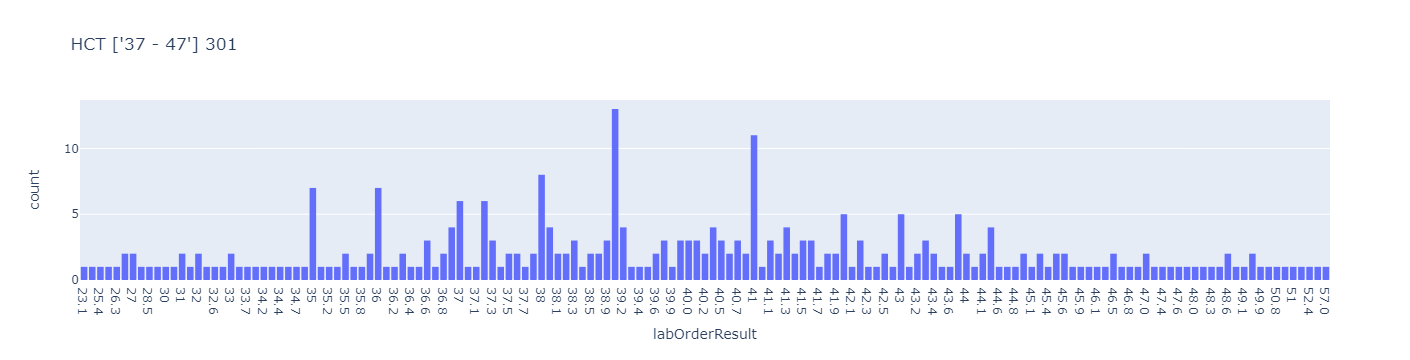

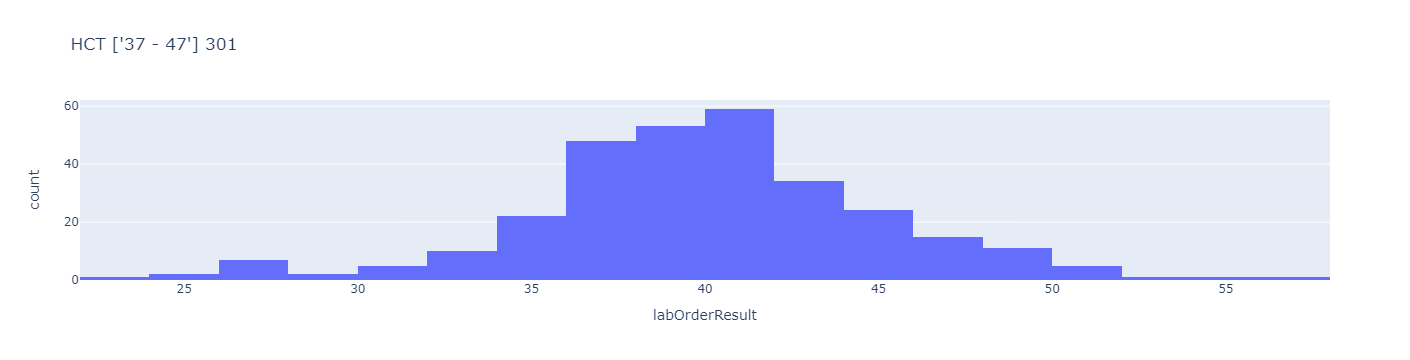

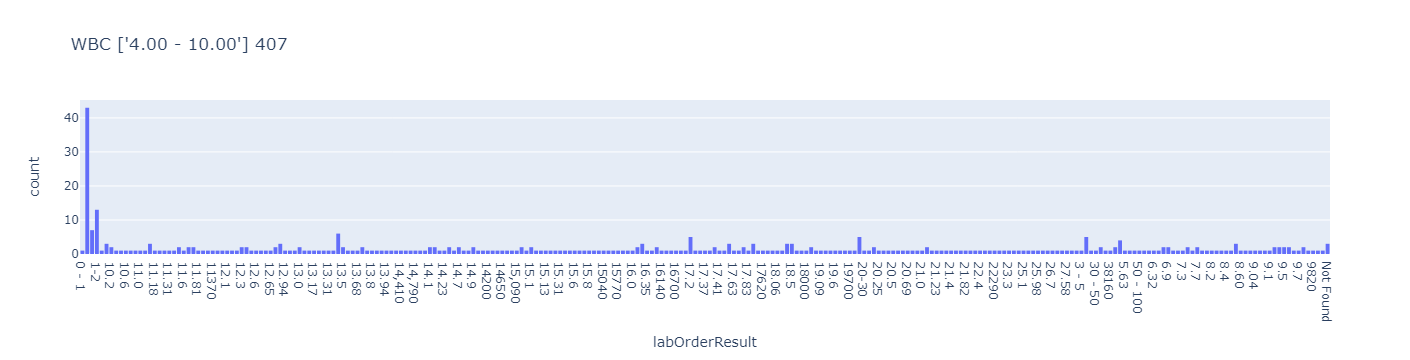

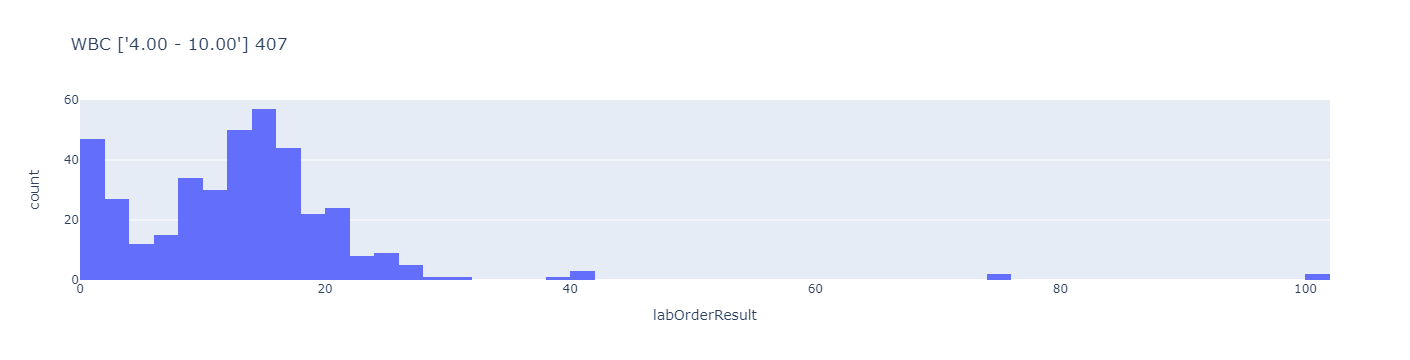

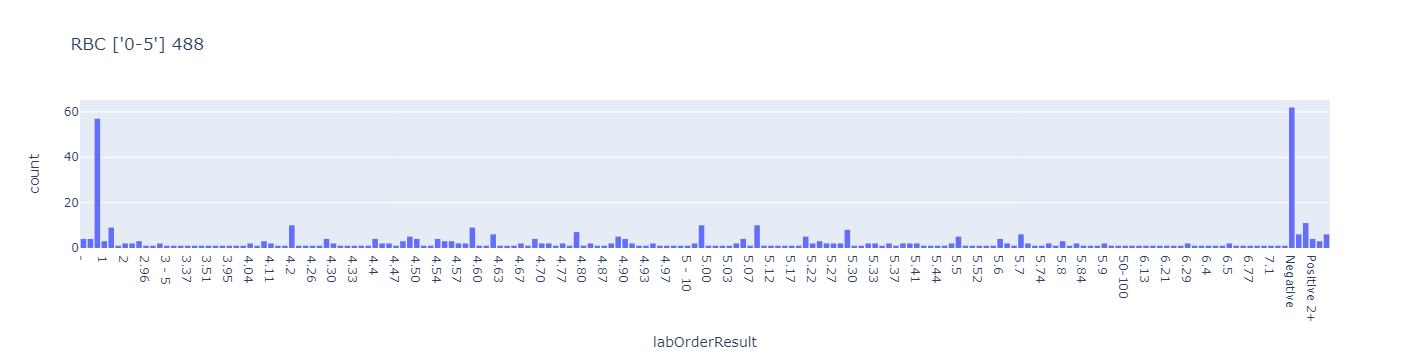

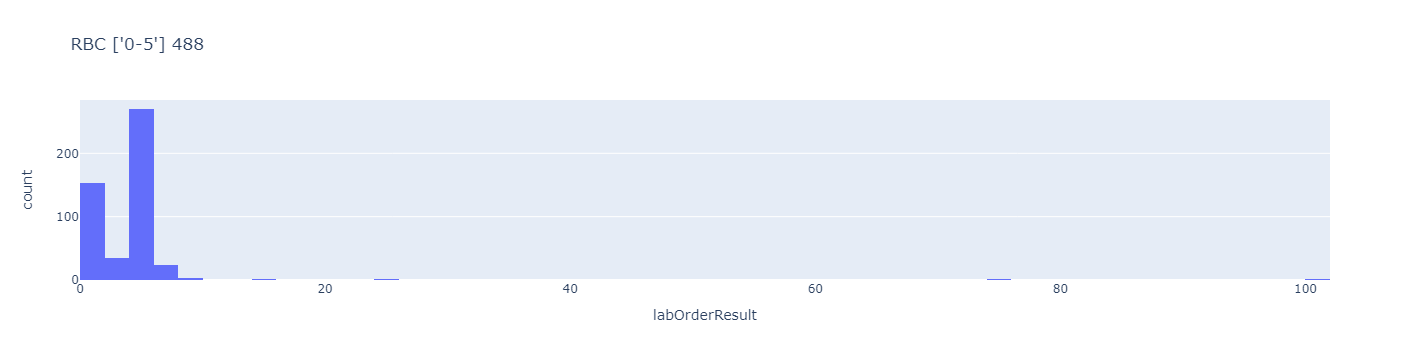

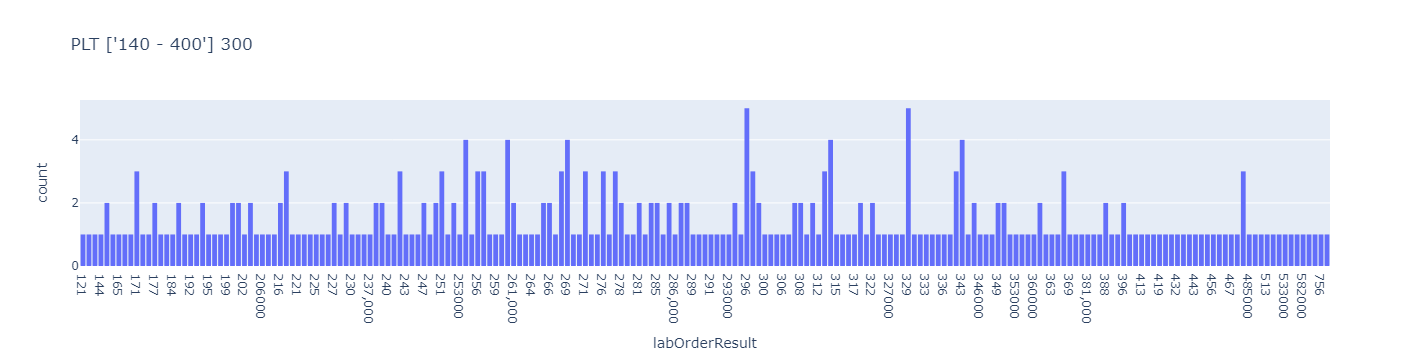

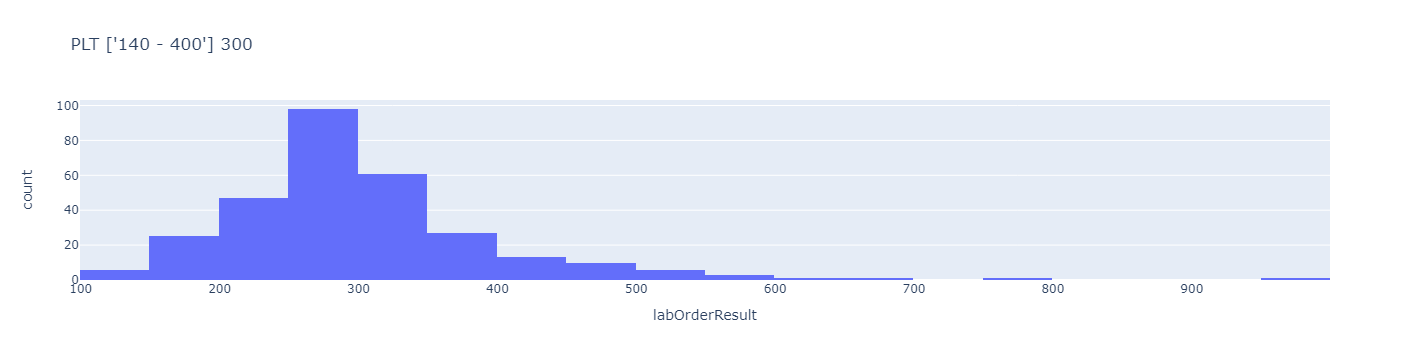

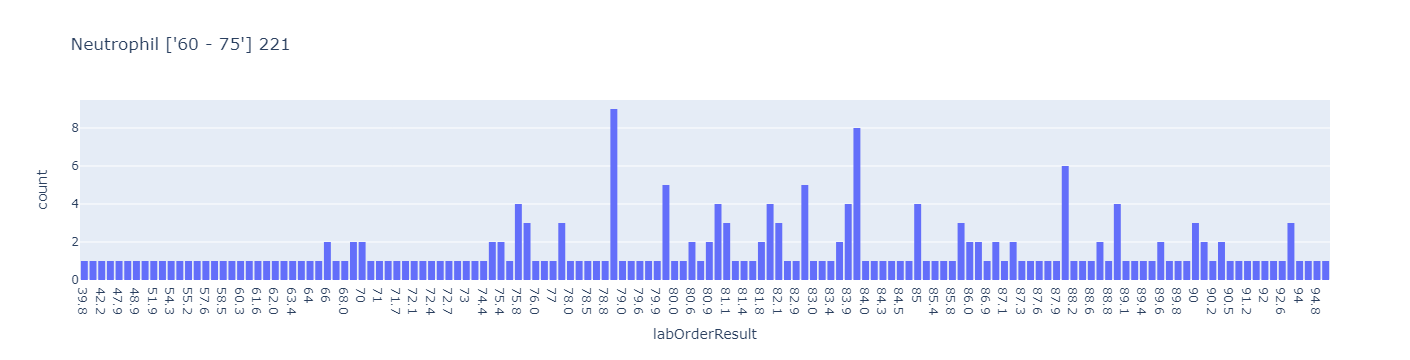

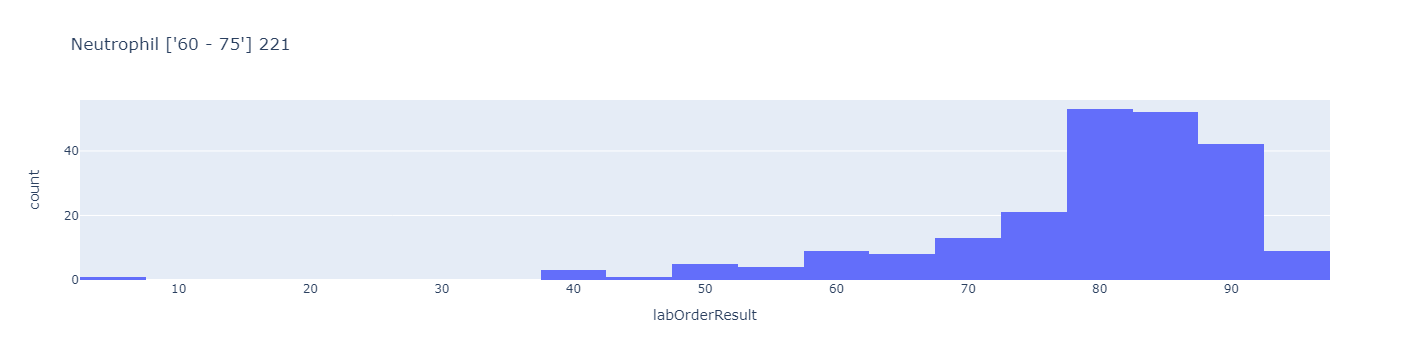

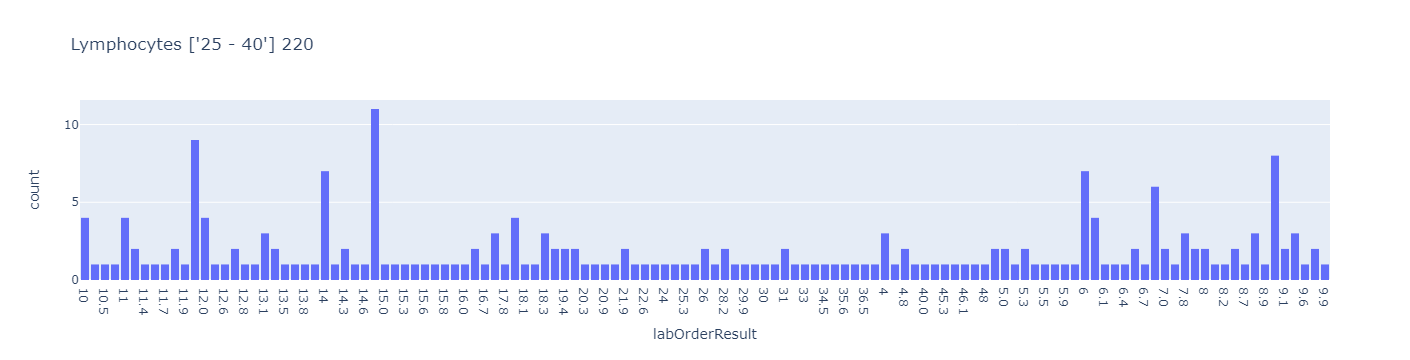

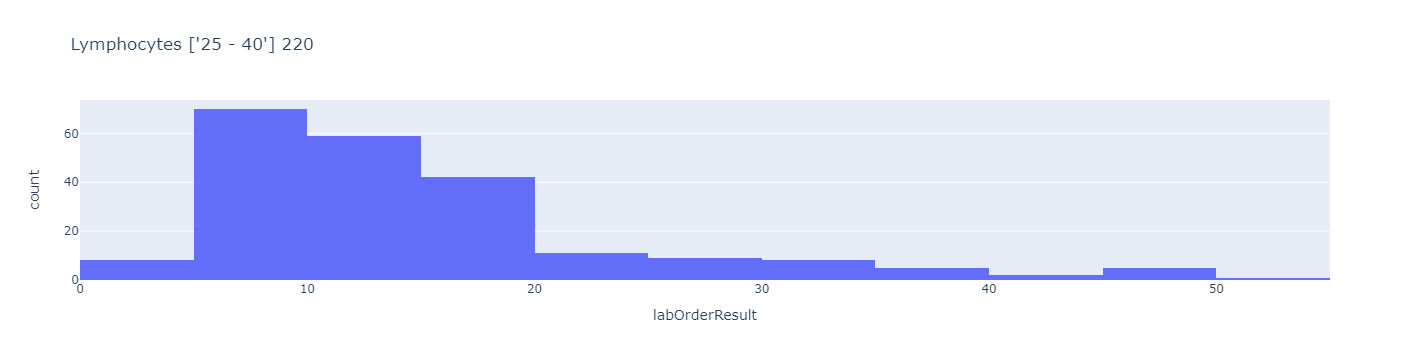

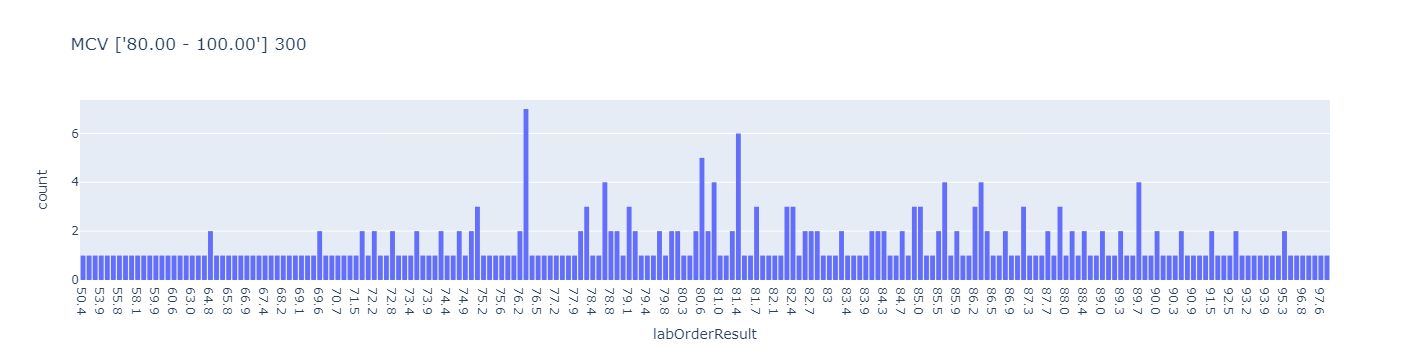

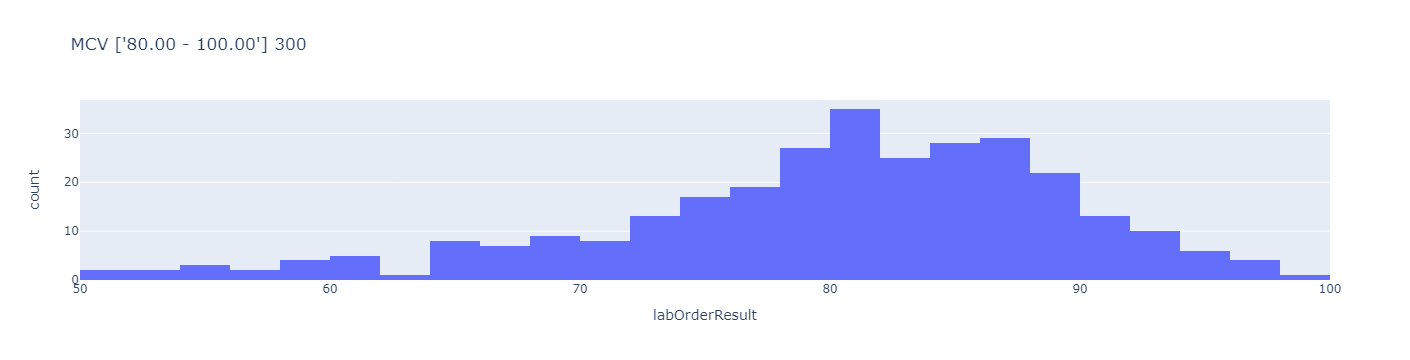

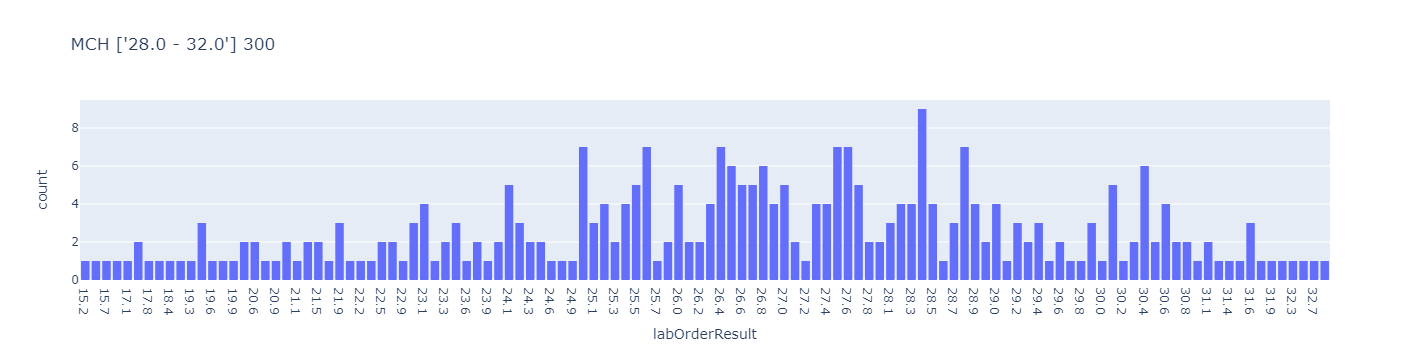

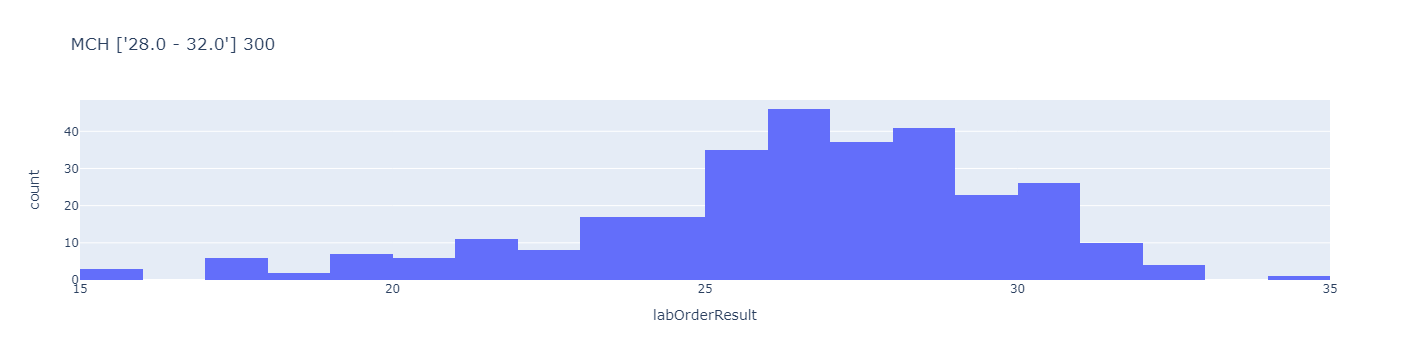

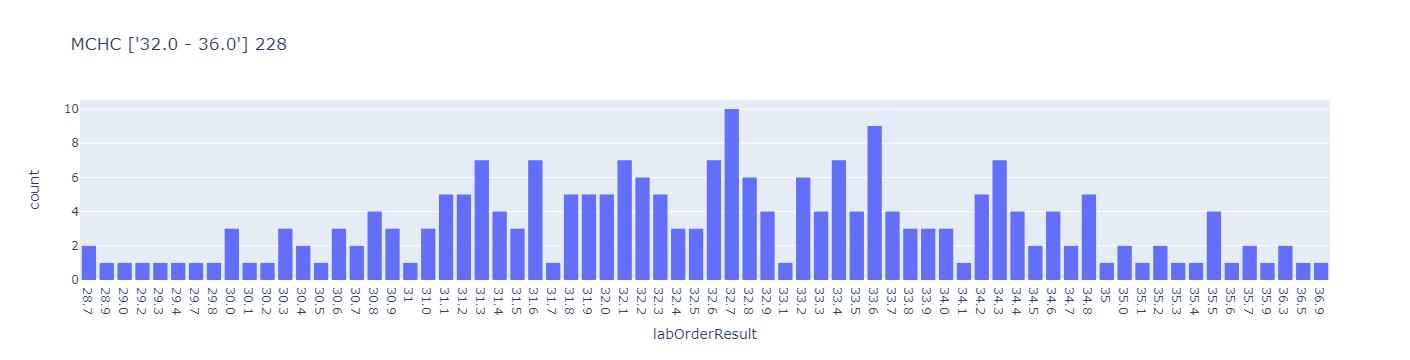

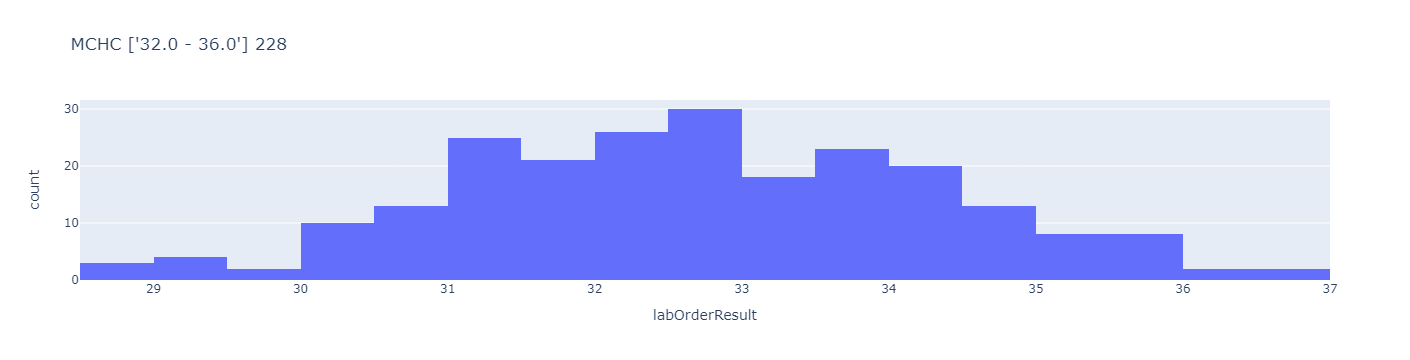

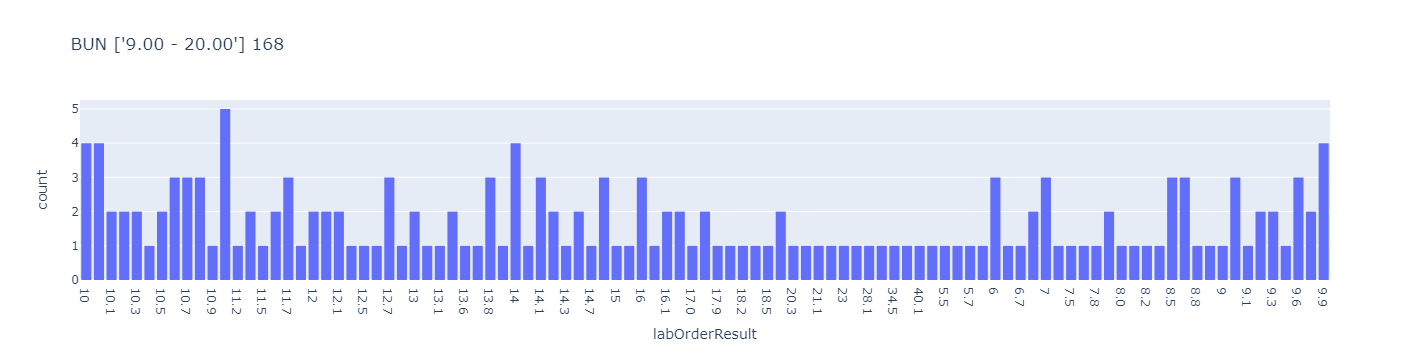

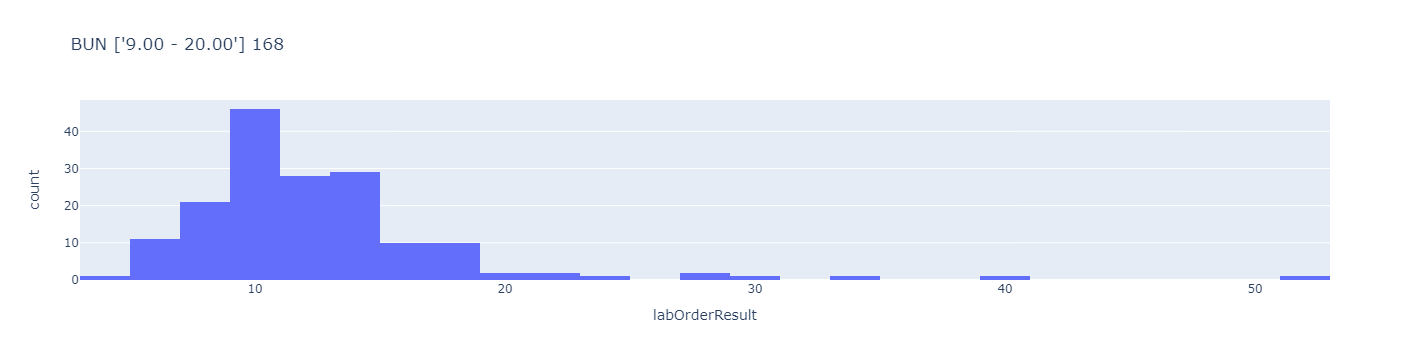

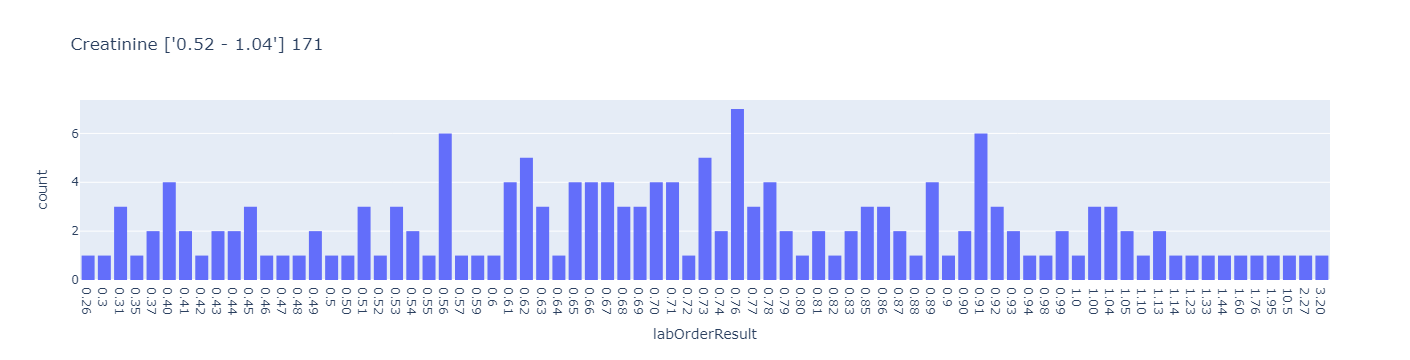

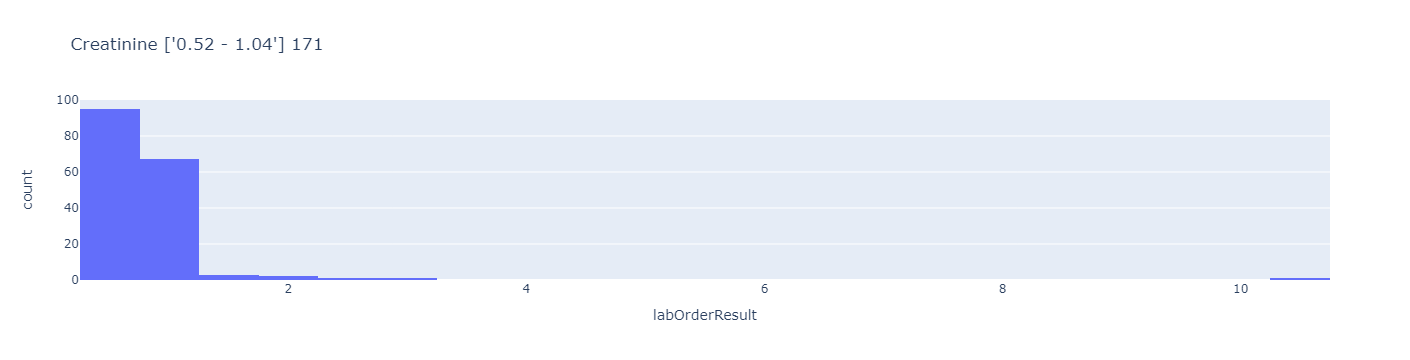

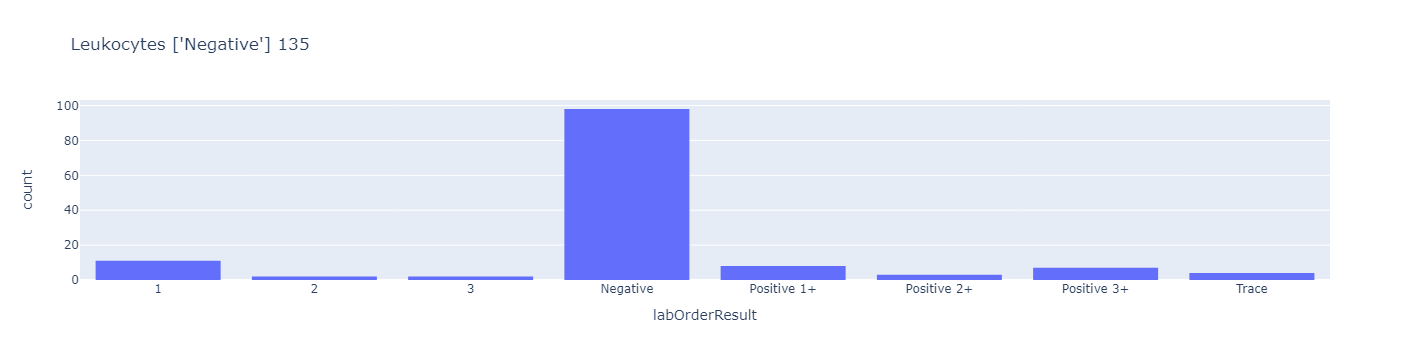

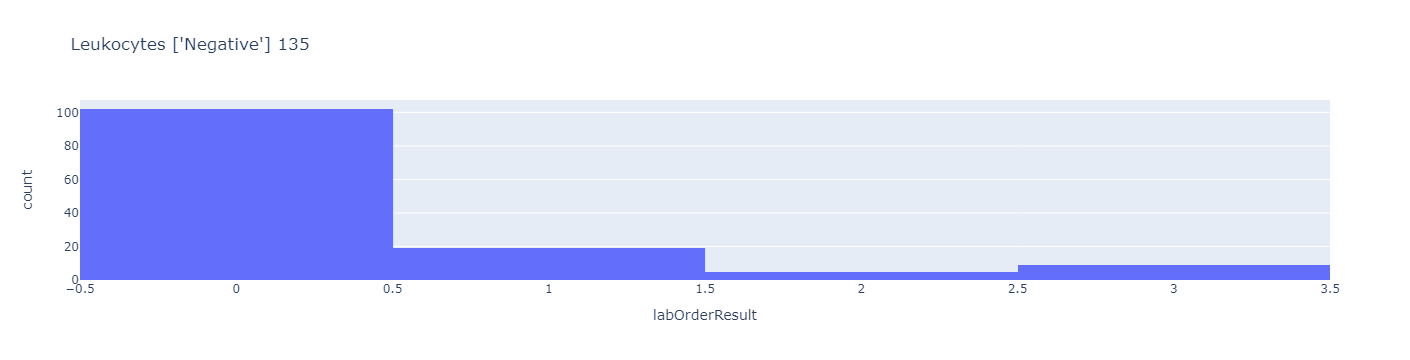

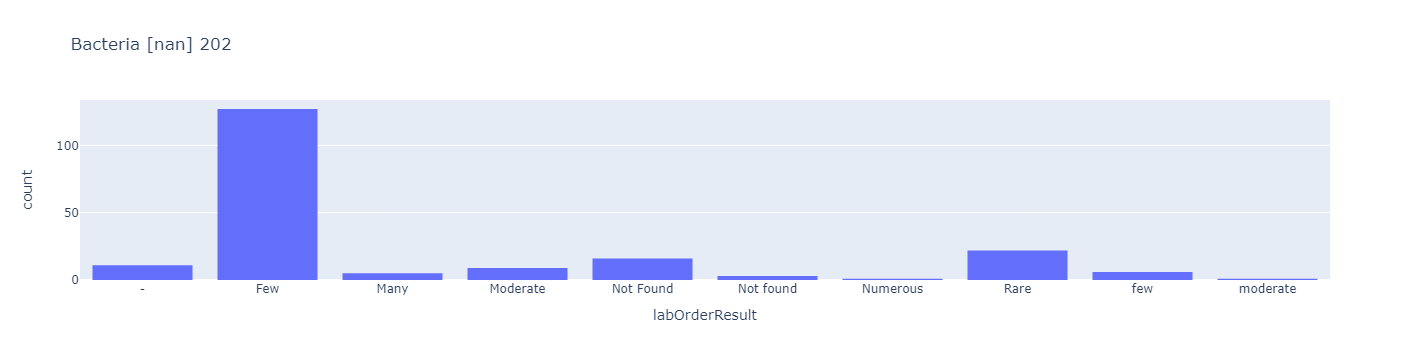

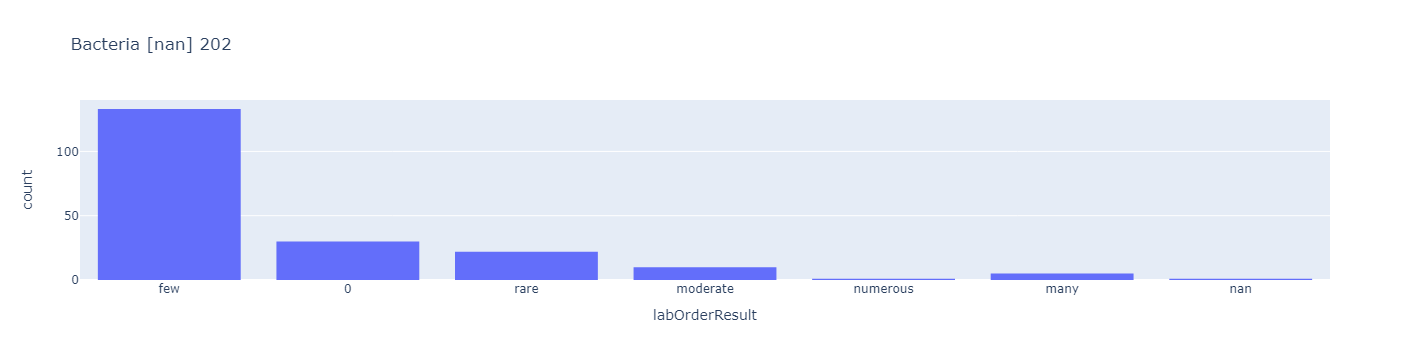

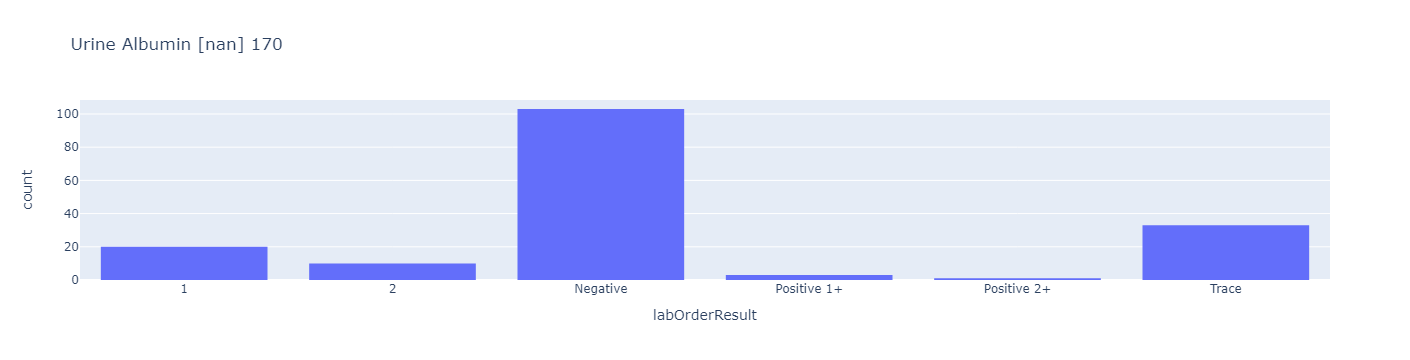

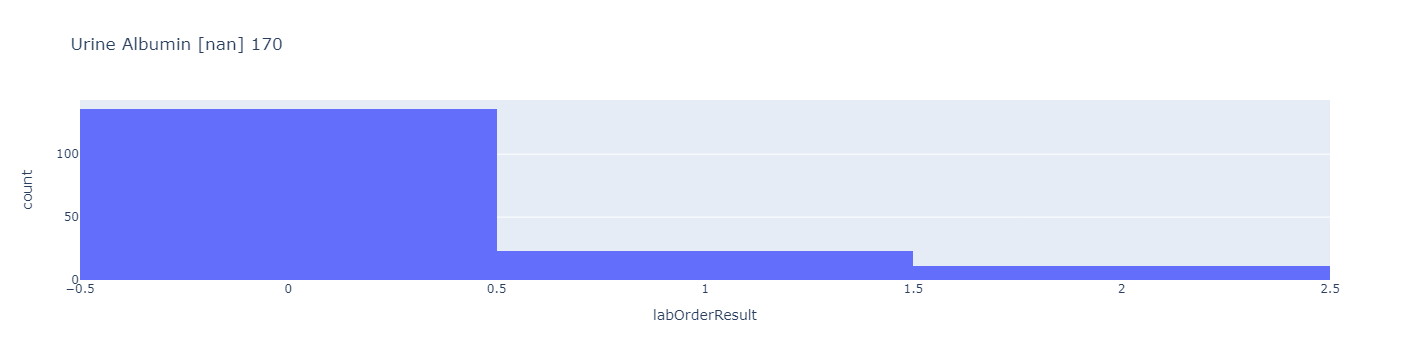

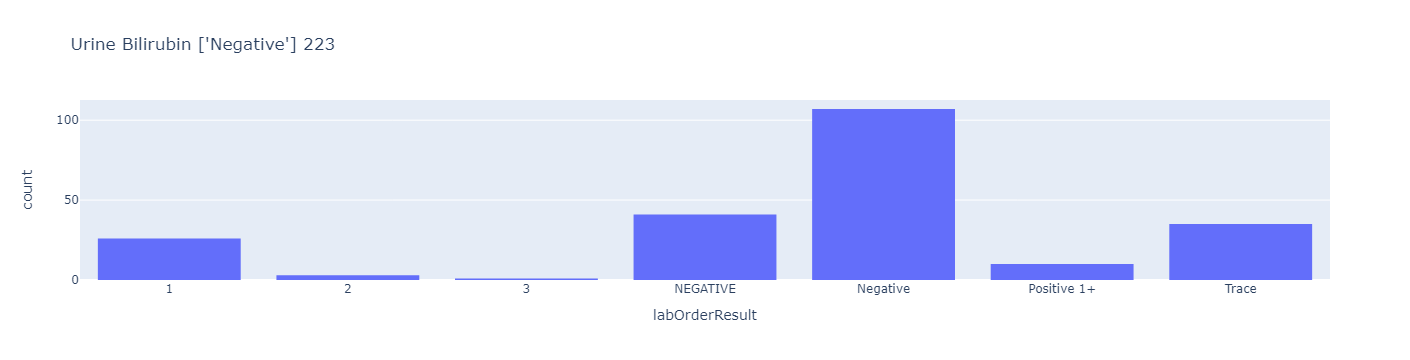

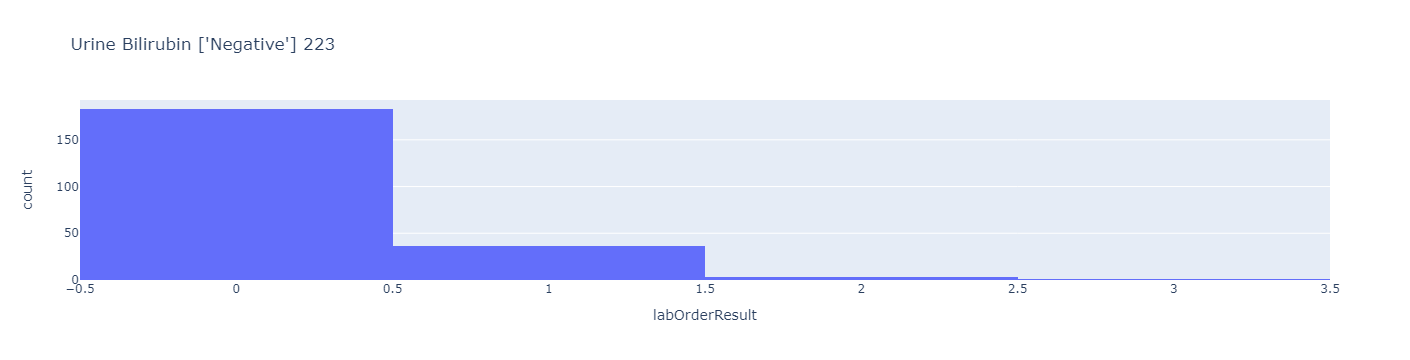

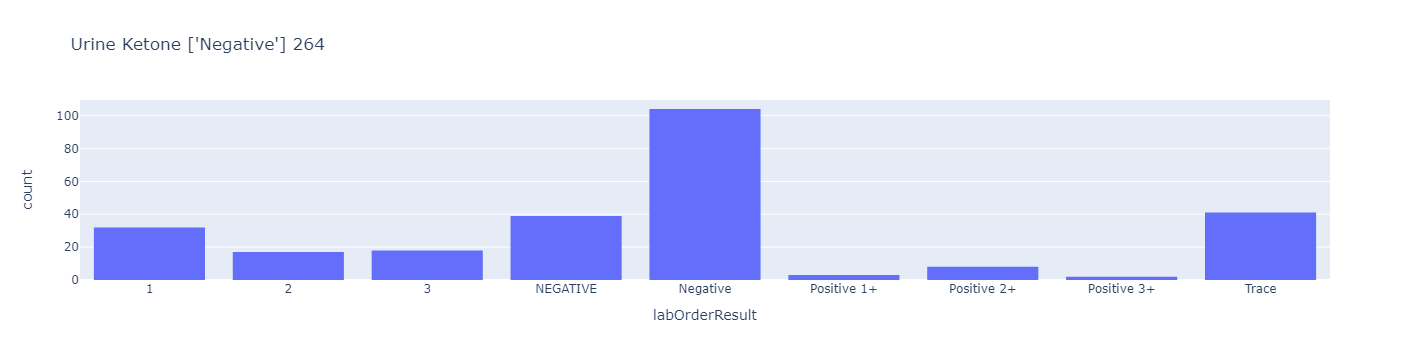

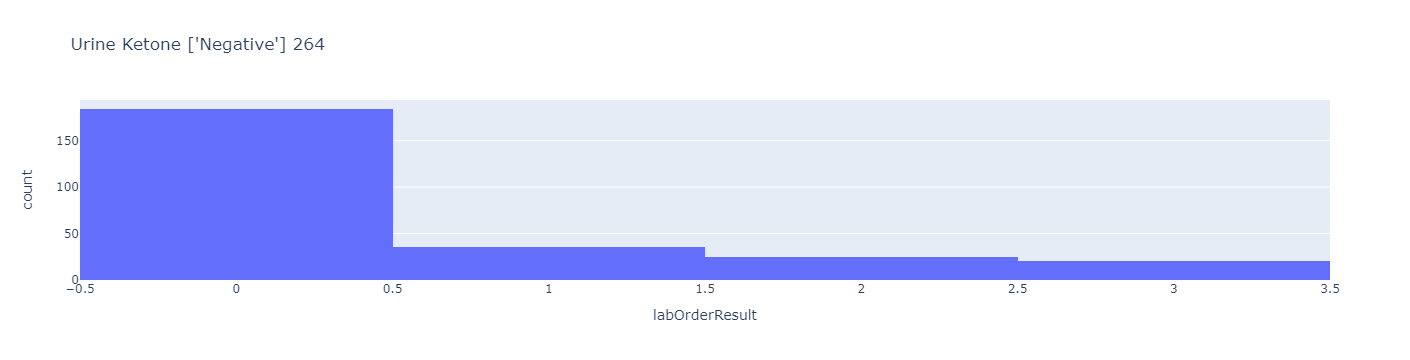

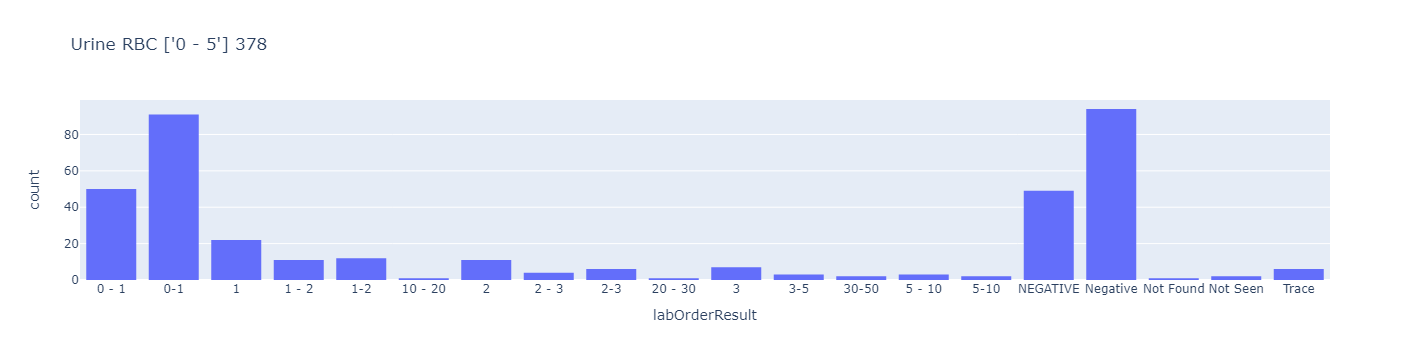

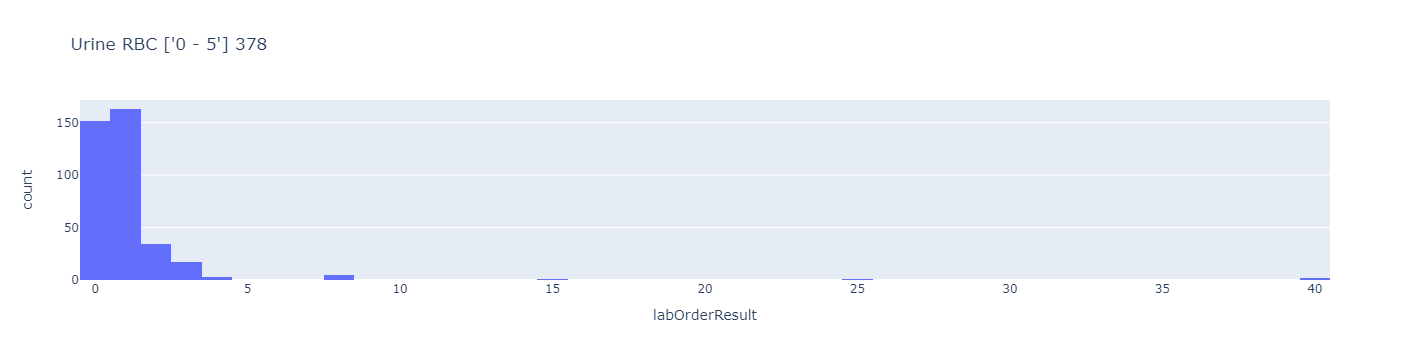

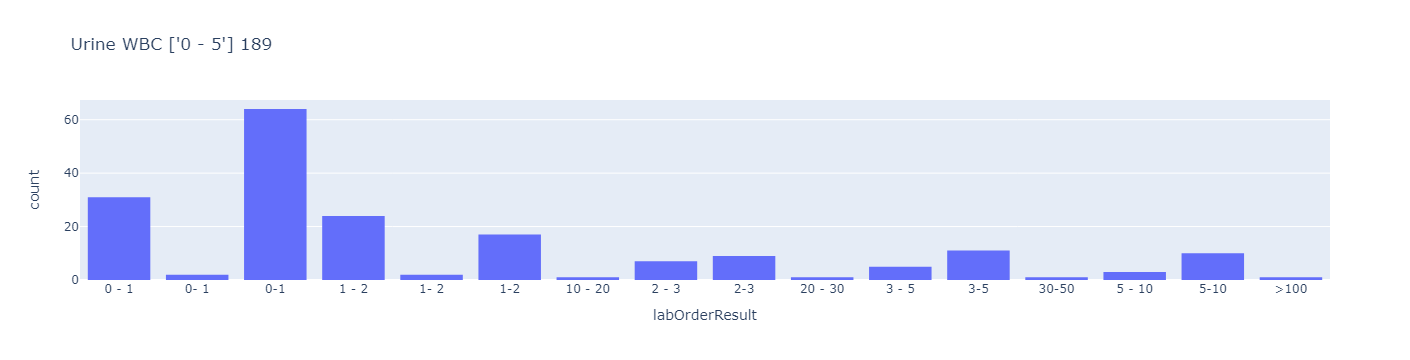

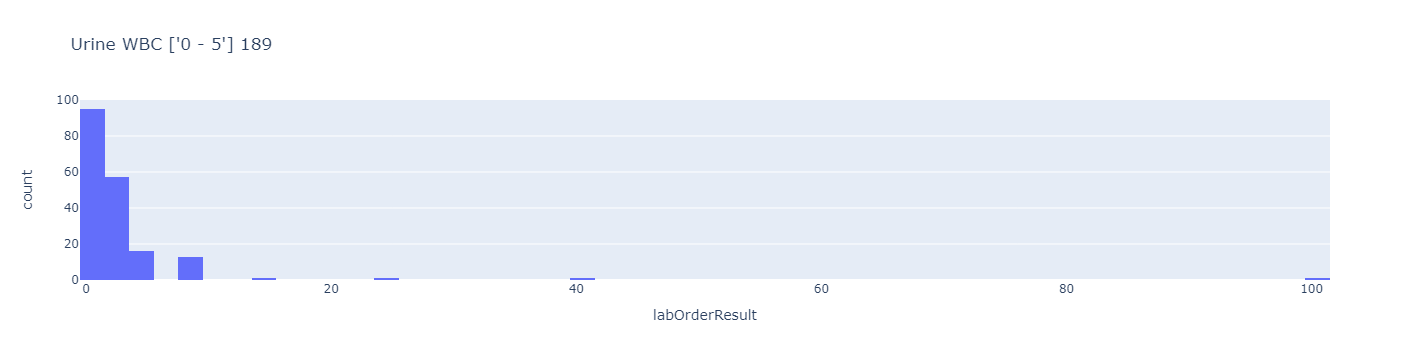

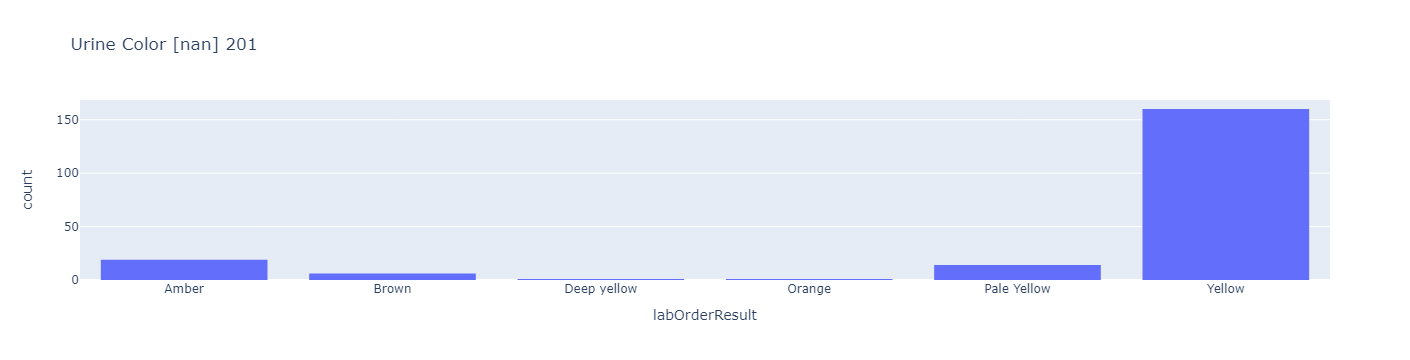

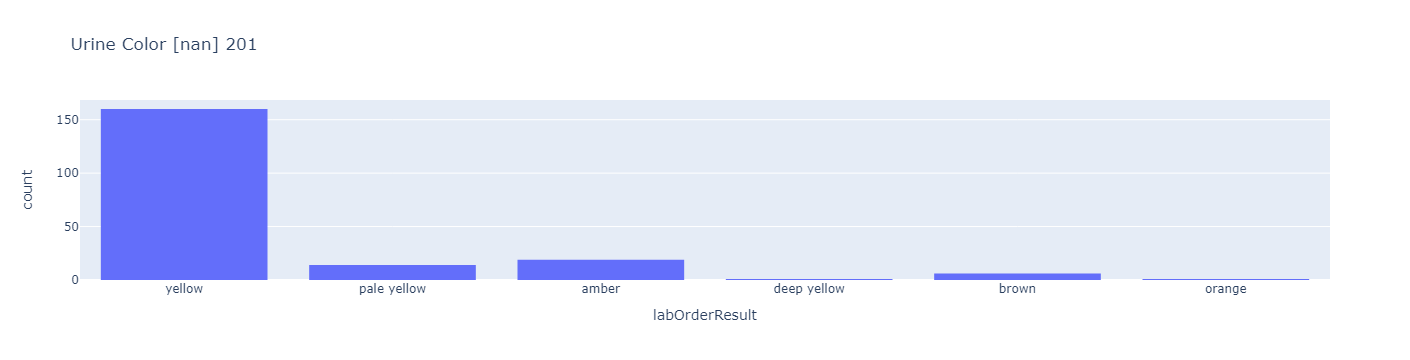

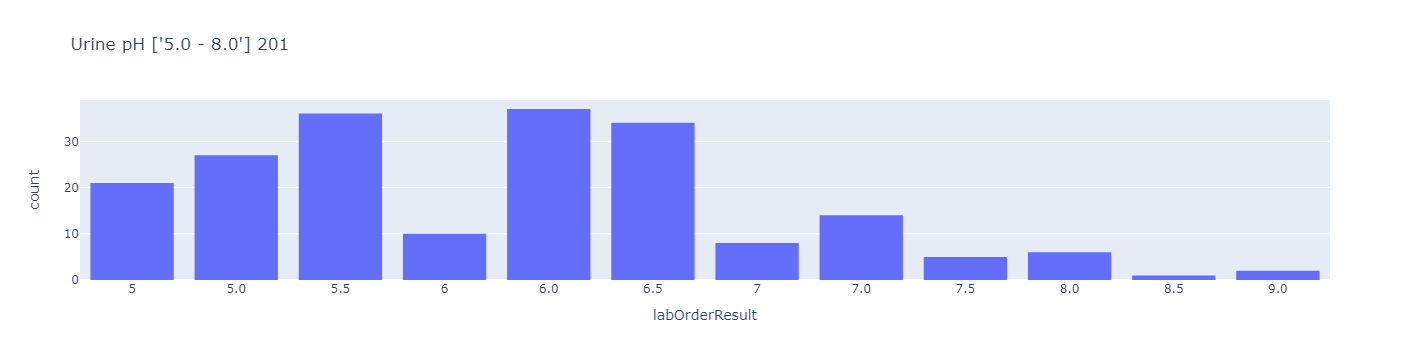

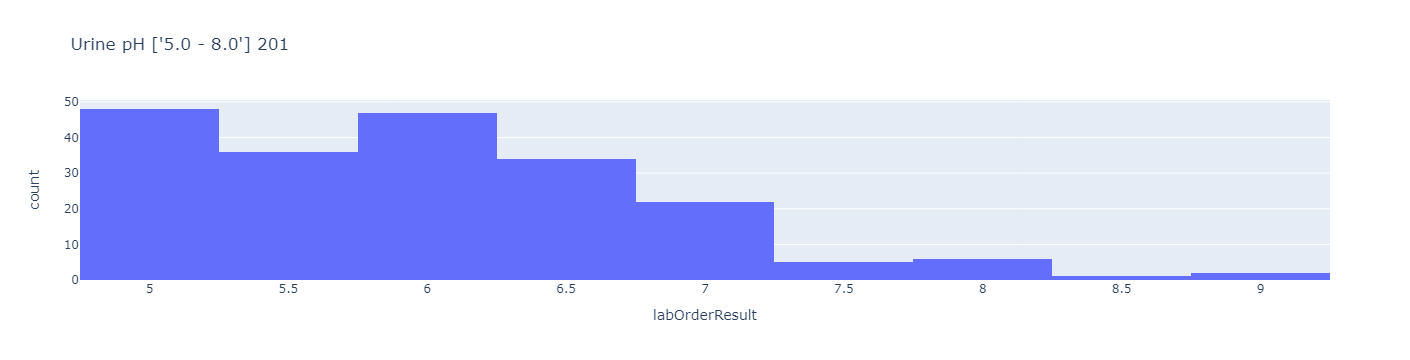

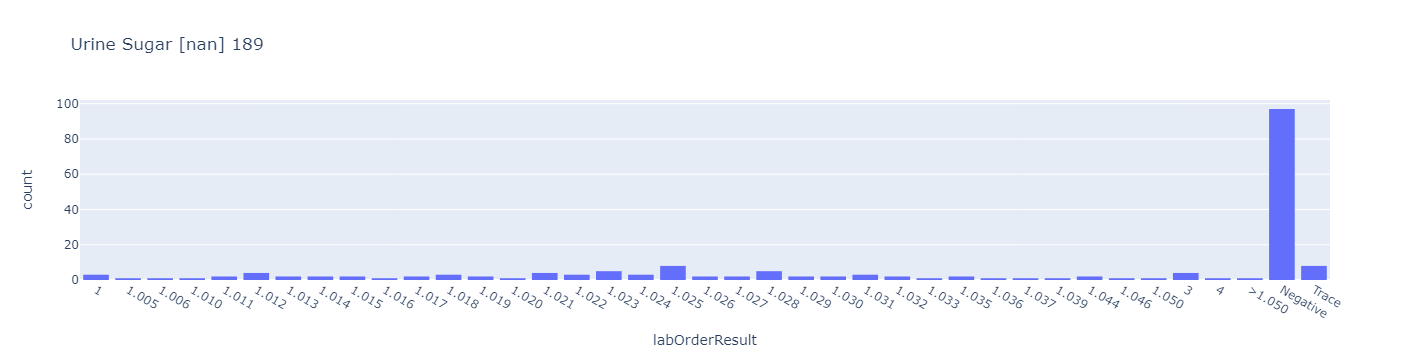

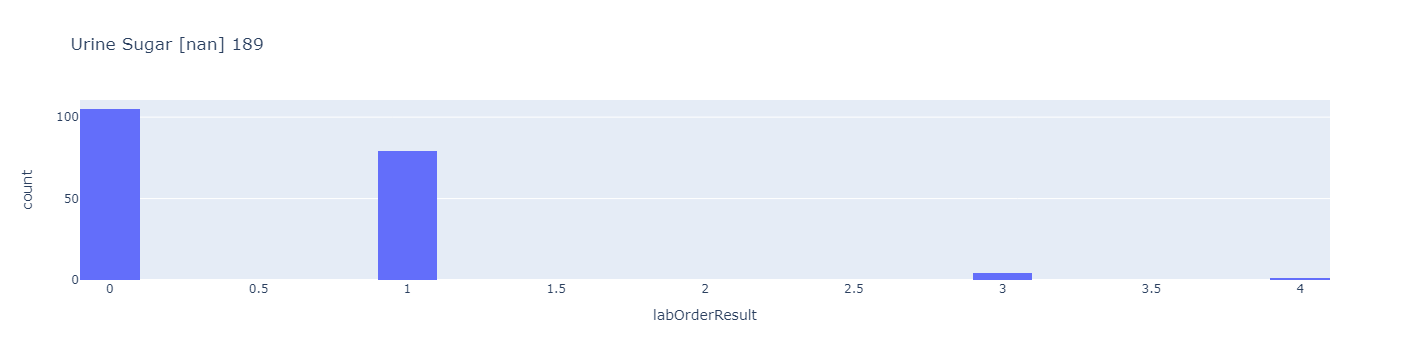

CPU times: total: 1.39 s
Wall time: 1.38 s


In [100]:
%%time
for lab in lab_names:
    df1 = lab_df.loc[lab_df['labItemsNameRef'] == lab].sort_values(by=['labOrderResult'])
    title = '%s %s %d'%(lab,df1['labItemsNormalValueRef'].unique(), len(df1))
    fig1 = px.histogram(data_frame = df1.sort_values(by=['labOrderResult']),x = "labOrderResult",title=title)
    
    df2 = lab_df.loc[lab_df['labItemsNameRef'] == lab]['labOrderResult'].apply(lab_conversion)
    
    fig2 = px.histogram(data_frame = df2,x = "labOrderResult",title=title)
    fig1.show(), fig2.show()
    

### Apply lab_conversion

In [101]:
lab_df['labOrderResult'] = lab_df['labOrderResult'].apply(lab_conversion)

In [102]:
lab_df.isna().sum()

rowID                        0
cid                          0
labItemsNameRef              0
labItemsNormalValueRef     762
labOrderResult               0
labItemsUnit              3575
dtype: int64

In [103]:
lab_df['labOrderResult'] = lab_df['labOrderResult'].astype(str)
df_port = pl.from_pandas(lab_df)
# columns= "labName"   values= "labResult" index= "rowID"
df_port = df_port.pivot(values= "labOrderResult", columns= "labItemsNameRef", index= "rowID", aggregate_fn= "max")
df_port = df_port.to_pandas()

In [104]:
df_port

,rowID,HCT,WBC,RBC,PLT,Neutrophil,Lymphocytes,MCV,MCH,MCHC,BUN,Creatinine,Leukocytes,Bacteria,Urine Albumin,Urine Bilirubin,Urine Ketone,Urine RBC,Urine WBC,Urine Color,Urine pH,Urine Sugar
0,601443,36.4,20.0,4.62,479.0,88.7,6.5,78.8,25.8,32.7,10.8,0.37,0,None,None,None,None,None,None,None,None,None
1,2981059,47.4,2,6.21,215.0,75.4,18.2,76.3,25.0,32.8,None,None,0,few,0,0,0,None,None,None,None,None
2,888917,41.0,8.0,4.8,345.0,69.3,25.3,85.6,27.6,None,5.6,0.55,None,few,2.0,0,0,1,2,yellow,6.5,0
3,4680522,36.9,14.16,4.5,290.0,85.0,12.0,82.4,26.1,31.7,10.0,0.45,0,few,0,None,3.0,1,1,yellow,5.5,0
4,4232190,37.2,8.34,6.4,314.0,54.4,39.6,58.1,19.3,33.2,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2431873,44.2,4.0,4.54,242.0,None,None,97.3,29.9,30.8,None,None,None,None,None,0,0,1,8,yellow,5.0,1.018
312,2146005,37.2,21.23,6.17,414.0,88.5,6.5,60.3,19.7,32.7,None,None,0,0,0,0,0,None,None,None,None,None
313,3873437,38.0,7.55,4.55,239.0,48.9,45.7,83.6,28.1,33.6,8.6,0.91,0,few,0,0,0,None,None,None,None,None
314,1466704,39.0,17.6,5.1,329.0,72.8,19.4,76.5,26.7,None,None,None,None,rare,0,0,0,1,1,yellow,7.0,0


In [105]:
df_port.isna().sum()

rowID                0
HCT                 16
WBC                 14
RBC                 14
PLT                 16
Neutrophil          96
Lymphocytes         96
MCV                 16
MCH                 16
MCHC                88
BUN                148
Creatinine         145
Leukocytes         183
Bacteria           117
Urine Albumin      149
Urine Bilirubin     96
Urine Ketone        56
Urine RBC          130
Urine WBC          130
Urine Color        118
Urine pH           118
Urine Sugar        130
dtype: int64

### Encoding

In [106]:
categorical_cols = ['Bacteria', 'Urine Color'] # 3 col

to_numeric = {
    # 'PLT Smear':{'adequate': 0, 'increase': 1,'slightly increase':2,'adequate with platelet clump':3,'slightly decrease':4},
    'Bacteria':{'nan':0,'0':0, 'rare':1, 'few': 1, 'moderate':2, 'many':3, 'numerous':4},
    'Urine Color': {'yellow': 0, 'pale yellow': 1, 'amber': 2, 'deep yellow': 3, 'brown': 4, 'orange': 5},
}

In [107]:
for col in categorical_cols:
    print(col,df_port[col].value_counts())

Bacteria few         130
0            30
rare         22
moderate     10
many          5
numerous      1
nan           1
Name: Bacteria, dtype: int64
Urine Color yellow         158
amber           19
pale yellow     14
brown            5
deep yellow      1
orange           1
Name: Urine Color, dtype: int64


In [108]:
df_port

,rowID,HCT,WBC,RBC,PLT,Neutrophil,Lymphocytes,MCV,MCH,MCHC,BUN,Creatinine,Leukocytes,Bacteria,Urine Albumin,Urine Bilirubin,Urine Ketone,Urine RBC,Urine WBC,Urine Color,Urine pH,Urine Sugar
0,601443,36.4,20.0,4.62,479.0,88.7,6.5,78.8,25.8,32.7,10.8,0.37,0,None,None,None,None,None,None,None,None,None
1,2981059,47.4,2,6.21,215.0,75.4,18.2,76.3,25.0,32.8,None,None,0,few,0,0,0,None,None,None,None,None
2,888917,41.0,8.0,4.8,345.0,69.3,25.3,85.6,27.6,None,5.6,0.55,None,few,2.0,0,0,1,2,yellow,6.5,0
3,4680522,36.9,14.16,4.5,290.0,85.0,12.0,82.4,26.1,31.7,10.0,0.45,0,few,0,None,3.0,1,1,yellow,5.5,0
4,4232190,37.2,8.34,6.4,314.0,54.4,39.6,58.1,19.3,33.2,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2431873,44.2,4.0,4.54,242.0,None,None,97.3,29.9,30.8,None,None,None,None,None,0,0,1,8,yellow,5.0,1.018
312,2146005,37.2,21.23,6.17,414.0,88.5,6.5,60.3,19.7,32.7,None,None,0,0,0,0,0,None,None,None,None,None
313,3873437,38.0,7.55,4.55,239.0,48.9,45.7,83.6,28.1,33.6,8.6,0.91,0,few,0,0,0,None,None,None,None,None
314,1466704,39.0,17.6,5.1,329.0,72.8,19.4,76.5,26.7,None,None,None,None,rare,0,0,0,1,1,yellow,7.0,0


In [109]:
for x in categorical_cols:
    if x in to_numeric:
        df_port[x] = df_port[x].map(lambda a: to_numeric[x][a] if a else None)

In [110]:
df_port[categorical_cols]

,Bacteria,Urine Color
0,NaN,NaN
1,1.0,NaN
2,1.0,0.0
3,1.0,0.0
4,NaN,NaN
...,...,...
311,NaN,0.0
312,0.0,NaN
313,1.0,NaN
314,1.0,0.0


In [111]:
df_port.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rowID            316 non-null    int64  
 1   HCT              300 non-null    object 
 2   WBC              302 non-null    object 
 3   RBC              302 non-null    object 
 4   PLT              300 non-null    object 
 5   Neutrophil       220 non-null    object 
 6   Lymphocytes      220 non-null    object 
 7   MCV              300 non-null    object 
 8   MCH              300 non-null    object 
 9   MCHC             228 non-null    object 
 10  BUN              168 non-null    object 
 11  Creatinine       171 non-null    object 
 12  Leukocytes       133 non-null    object 
 13  Bacteria         199 non-null    float64
 14  Urine Albumin    167 non-null    object 
 15  Urine Bilirubin  220 non-null    object 
 16  Urine Ketone     260 non-null    object 
 17  Urine RBC       

In [112]:
df_port.isna().sum()

rowID                0
HCT                 16
WBC                 14
RBC                 14
PLT                 16
Neutrophil          96
Lymphocytes         96
MCV                 16
MCH                 16
MCHC                88
BUN                148
Creatinine         145
Leukocytes         183
Bacteria           117
Urine Albumin      149
Urine Bilirubin     96
Urine Ketone        56
Urine RBC          130
Urine WBC          130
Urine Color        118
Urine pH           118
Urine Sugar        130
dtype: int64

In [113]:
df_port.replace('', np.nan).dropna(subset=df_port.columns, inplace=True)

In [114]:
df_port

,rowID,HCT,WBC,RBC,PLT,Neutrophil,Lymphocytes,MCV,MCH,MCHC,BUN,Creatinine,Leukocytes,Bacteria,Urine Albumin,Urine Bilirubin,Urine Ketone,Urine RBC,Urine WBC,Urine Color,Urine pH,Urine Sugar
0,601443,36.4,20.0,4.62,479.0,88.7,6.5,78.8,25.8,32.7,10.8,0.37,0,NaN,None,None,None,None,None,NaN,None,None
1,2981059,47.4,2,6.21,215.0,75.4,18.2,76.3,25.0,32.8,None,None,0,1.0,0,0,0,None,None,NaN,None,None
2,888917,41.0,8.0,4.8,345.0,69.3,25.3,85.6,27.6,None,5.6,0.55,None,1.0,2.0,0,0,1,2,0.0,6.5,0
3,4680522,36.9,14.16,4.5,290.0,85.0,12.0,82.4,26.1,31.7,10.0,0.45,0,1.0,0,None,3.0,1,1,0.0,5.5,0
4,4232190,37.2,8.34,6.4,314.0,54.4,39.6,58.1,19.3,33.2,None,None,None,NaN,None,None,None,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2431873,44.2,4.0,4.54,242.0,None,None,97.3,29.9,30.8,None,None,None,NaN,None,0,0,1,8,0.0,5.0,1.018
312,2146005,37.2,21.23,6.17,414.0,88.5,6.5,60.3,19.7,32.7,None,None,0,0.0,0,0,0,None,None,NaN,None,None
313,3873437,38.0,7.55,4.55,239.0,48.9,45.7,83.6,28.1,33.6,8.6,0.91,0,1.0,0,0,0,None,None,NaN,None,None
314,1466704,39.0,17.6,5.1,329.0,72.8,19.4,76.5,26.7,None,None,None,None,1.0,0,0,0,1,1,0.0,7.0,0


In [115]:
df_port[df_port.columns] = df_port[df_port.columns].apply(pd.to_numeric, errors='coerce')

In [116]:
df_port

,rowID,HCT,WBC,RBC,PLT,Neutrophil,Lymphocytes,MCV,MCH,MCHC,BUN,Creatinine,Leukocytes,Bacteria,Urine Albumin,Urine Bilirubin,Urine Ketone,Urine RBC,Urine WBC,Urine Color,Urine pH,Urine Sugar
0,601443,36.4,20.00,4.62,479.0,88.7,6.5,78.8,25.8,32.7,10.8,0.37,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2981059,47.4,2.00,6.21,215.0,75.4,18.2,76.3,25.0,32.8,NaN,NaN,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,888917,41.0,8.00,4.80,345.0,69.3,25.3,85.6,27.6,NaN,5.6,0.55,NaN,1.0,2.0,0.0,0.0,1.0,2.0,0.0,6.5,0.000
3,4680522,36.9,14.16,4.50,290.0,85.0,12.0,82.4,26.1,31.7,10.0,0.45,0.0,1.0,0.0,NaN,3.0,1.0,1.0,0.0,5.5,0.000
4,4232190,37.2,8.34,6.40,314.0,54.4,39.6,58.1,19.3,33.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2431873,44.2,4.00,4.54,242.0,NaN,NaN,97.3,29.9,30.8,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,8.0,0.0,5.0,1.018
312,2146005,37.2,21.23,6.17,414.0,88.5,6.5,60.3,19.7,32.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
313,3873437,38.0,7.55,4.55,239.0,48.9,45.7,83.6,28.1,33.6,8.6,0.91,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
314,1466704,39.0,17.60,5.10,329.0,72.8,19.4,76.5,26.7,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,0.000


In [117]:
df_port.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rowID            316 non-null    int64  
 1   HCT              300 non-null    float64
 2   WBC              289 non-null    float64
 3   RBC              302 non-null    float64
 4   PLT              300 non-null    float64
 5   Neutrophil       220 non-null    float64
 6   Lymphocytes      220 non-null    float64
 7   MCV              300 non-null    float64
 8   MCH              300 non-null    float64
 9   MCHC             228 non-null    float64
 10  BUN              167 non-null    float64
 11  Creatinine       170 non-null    float64
 12  Leukocytes       133 non-null    float64
 13  Bacteria         199 non-null    float64
 14  Urine Albumin    167 non-null    float64
 15  Urine Bilirubin  220 non-null    float64
 16  Urine Ketone     260 non-null    float64
 17  Urine RBC       

In [118]:
df_port.describe().T

,count,mean,std,min,25%,50%,75%,max
rowID,316.0,2.341799e+06,1.798909e+06,342.00,836372.500,1884959.50,3.767696e+06,6213562.0
HCT,300.0,3.986700e+01,5.182923e+00,23.10,37.000,39.95,4.300000e+01,57.0
WBC,289.0,1.435806e+01,7.144253e+00,1.00,9.930,14.10,1.762000e+01,75.0
RBC,302.0,5.261325e+00,4.106065e+00,1.00,4.560,5.00,5.427500e+00,75.0
PLT,300.0,3.023333e+02,1.003672e+02,121.00,246.750,286.00,3.400000e+02,989.0
Neutrophil,220.0,7.925455e+01,1.106013e+01,39.80,75.800,81.90,8.702500e+01,95.0
Lymphocytes,220.0,1.489818e+01,9.627069e+00,3.00,8.500,12.20,1.800000e+01,52.5
MCV,300.0,8.002833e+01,9.346798e+00,50.40,75.100,81.35,8.640000e+01,98.6
MCH,300.0,2.635733e+01,3.414534e+00,15.20,24.675,26.80,2.872500e+01,34.1
MCHC,228.0,3.267281e+01,1.641117e+00,28.70,31.475,32.65,3.380000e+01,36.9


## 2. Pairplot

In [119]:
df_port.corr()

,rowID,HCT,WBC,RBC,PLT,Neutrophil,Lymphocytes,MCV,MCH,MCHC,BUN,Creatinine,Leukocytes,Bacteria,Urine Albumin,Urine Bilirubin,Urine Ketone,Urine RBC,Urine WBC,Urine Color,Urine pH,Urine Sugar
rowID,1.000000,0.001615,-0.072153,-0.005685,0.024763,-0.080517,0.084151,-0.019316,0.043915,0.211600,0.003357,-0.082284,-0.047171,-0.040790,-0.082643,-0.097976,0.027765,-0.101445,-0.037892,-0.129337,-0.202553,-0.228460
HCT,0.001615,1.000000,0.000277,0.059565,-0.321113,-0.010462,-0.019346,0.447030,0.393883,0.069285,-0.086170,-0.200638,-0.162699,-0.072180,0.020760,0.054725,-0.061834,0.100107,-0.063162,0.008405,0.020005,0.215879
WBC,-0.072153,0.000277,1.000000,0.008658,0.124185,0.363497,-0.377891,-0.058049,-0.056225,-0.055529,-0.200119,-0.117560,0.327058,0.055002,0.068142,0.078592,0.151636,0.057970,0.010248,0.123518,-0.116139,-0.053767
RBC,-0.005685,0.059565,0.008658,1.000000,-0.043043,0.037041,-0.037146,-0.017611,0.008435,0.079129,-0.092071,-0.040871,0.259435,-0.134925,-0.002073,-0.003193,0.094759,0.104680,-0.082273,-0.014001,-0.006100,0.039802
PLT,0.024763,-0.321113,0.124185,-0.043043,1.000000,0.077677,-0.070660,-0.259911,-0.285985,-0.206508,-0.161267,-0.193221,-0.038744,-0.048823,0.039832,-0.036238,0.047559,0.002127,-0.032848,0.091239,-0.116612,-0.069452
Neutrophil,-0.080517,-0.010462,0.363497,0.037041,0.077677,1.000000,-0.976364,-0.130464,-0.078777,0.096557,-0.035529,-0.045754,0.076633,-0.025381,0.143366,0.120084,0.261129,0.043258,0.049977,0.179600,-0.037372,0.127713
Lymphocytes,0.084151,-0.019346,-0.377891,-0.037146,-0.070660,-0.976364,1.000000,0.111147,0.053867,-0.110227,0.054263,0.036788,-0.072860,0.022739,-0.141652,-0.139010,-0.242746,-0.019514,-0.043237,-0.174467,0.031463,-0.111759
MCV,-0.019316,0.447030,-0.058049,-0.017611,-0.259911,-0.130464,0.111147,1.000000,0.930238,0.194909,-0.138036,0.022946,0.028514,0.060740,-0.175932,-0.091320,-0.068531,-0.029158,0.012523,-0.002466,0.024397,0.187460
MCH,0.043915,0.393883,-0.056225,0.008435,-0.285985,-0.078777,0.053867,0.930238,1.000000,0.536191,-0.138215,0.026501,0.013176,-0.003113,-0.125099,-0.114606,-0.044936,-0.086938,-0.014395,-0.120534,0.062902,0.026021
MCHC,0.211600,0.069285,-0.055529,0.079129,-0.206508,0.096557,-0.110227,0.194909,0.536191,1.000000,-0.036387,0.016617,-0.038871,-0.254496,0.102286,-0.049659,0.059900,-0.161446,-0.089809,-0.310353,0.006308,-0.337409


## 3. Pearson Correlation Matrix

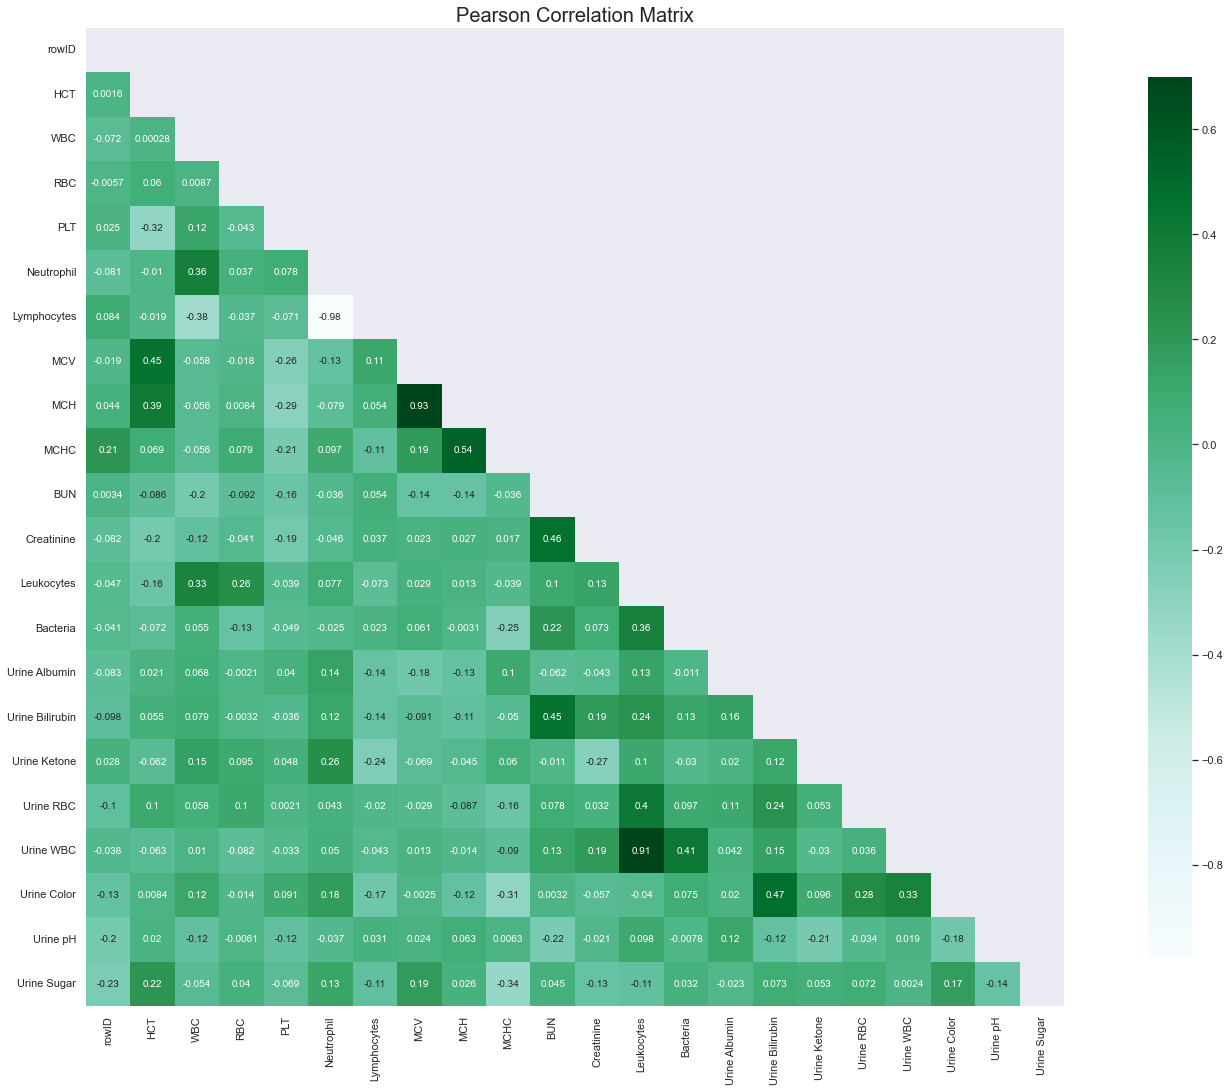

In [120]:

mask = np.zeros_like(df_port.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(30, 18))
plt.title('Pearson Correlation Matrix',fontsize=20)

sns.heatmap(df_port.corr(),linewidths=0,vmax=0.7,square=True,cmap='BuGn', 
            linecolor='w',annot=True,annot_kws={"size":10},mask=mask,cbar_kws={"shrink": .9});

## 4. Boxplot

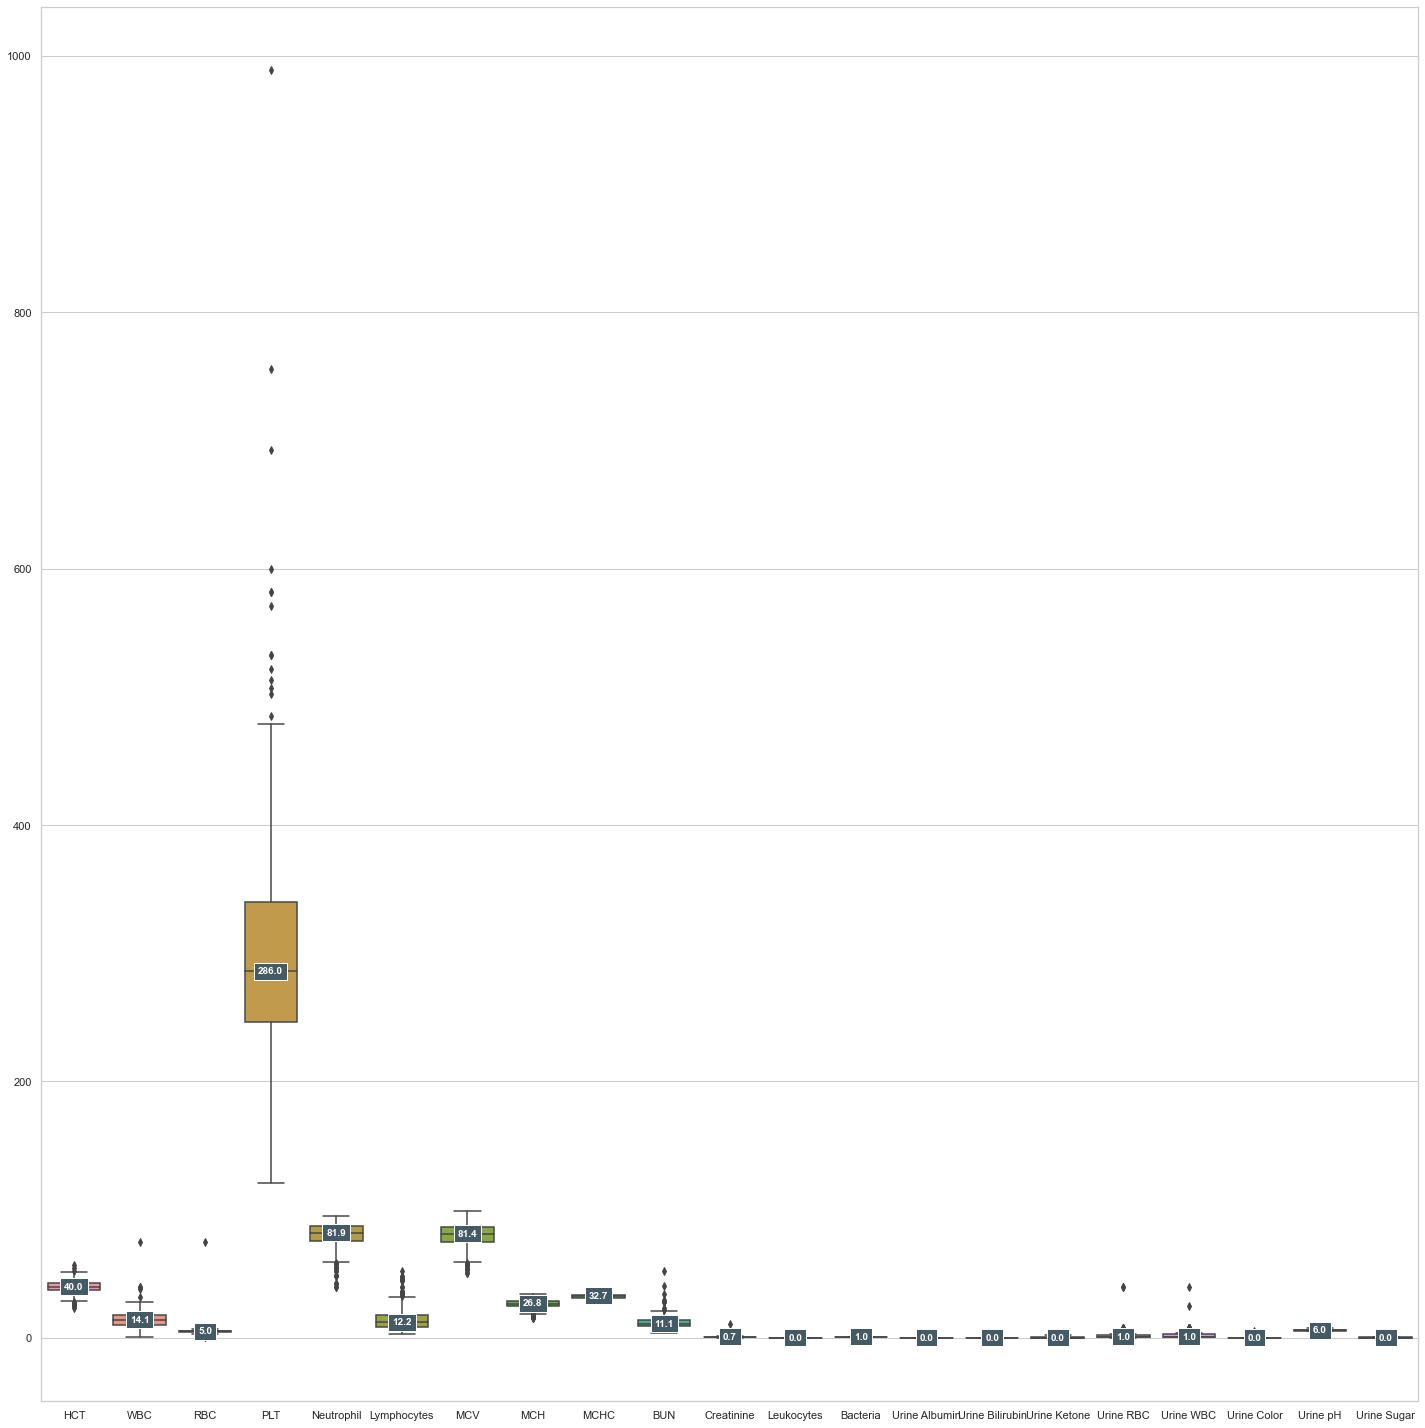

In [121]:
# Style 
sns.set_theme(style="whitegrid")
df4 = df_port.drop(['rowID'], axis=1)
# Plot
box_plot = sns.boxplot(data = df4)
sns.set(rc={'figure.figsize':(20,20)})
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()


for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

box_plot.figure.tight_layout()

In [122]:
'''
Normal value of 'PLT' == 140-400'

The normal range of platelet count (PLT) in adults is typically between 150,000 to 450,000 platelets per microliter (µL) of blood. 
However, the actual maximum value of PLT can vary depending on:
various factors such as 
- age, 
- gender, 
- health status, 
- and medical history of the individual.
'''
df_port['PLT'].describe()

count    300.000000
mean     302.333333
std      100.367163
min      121.000000
25%      246.750000
50%      286.000000
75%      340.000000
max      989.000000
Name: PLT, dtype: float64

# Patient

In [123]:
path = 'raw.csv'
patient_df = pd.read_csv(path)

In [124]:
patient_df

,rowID,cid,class,visitDateTime,hospCode,diagText,diagnoses,admission,labResults,patientDOB,patientSexName,patientAddress,drugs,billingItems,xrays,patientAge,icd10_list,diagType_1,diagType_2,diagType_3,diagType_4,diagType_5,address_houseNumber,address_moopart,address_road,address_tmbpart,address_amppart,address_chwpart,address_addressPart,address_country,vital_bpd,vital_bps,vital_bw,vital_cc,vital_hr,vital_pe,vital_pulse,vital_temperature,vital_rr,vital_height,vital_fbs,vital_bmi,vital_waist,vital_o2sat,vital_prePainScore,vital_postPainScore,vital_peGa,vital_peHeent,vital_peHeart,vital_peLung,vital_peAb,vital_peExt,vital_peNeuro,vital_peGaText,vital_peHeentText,vital_peHeartText,vital_peLungText,vital_peAbText,vital_peNeuroText,vital_peExtText,vital_hpi,vital_pmh,vital_fh,vital_sh,vital_ros,exercise,alcohol,smoking,narcotic
0,2946013,b229579fa0cfbf08dc9cc3b6348c9aa3f49ff05ef354a1...,AMB,2021-01-14 08:59:46,10685,NaN,"[{""icd10"":""K36"",""icd10Name"":""Other appendiciti...",NaN,[],1979-01-01 00:00:00 UTC,0,"[{""houseNumber"":""ห้องเช่า"",""moopart"":""0"",""road...","[{""qty"":""20"",""drugNondugName"":""AMOXICILLIN+CLA...","[{""billingStatus"":""PROCESSING"",""hospCode"":""106...",[],42,['K36'],['K36'],NaN,NaN,NaN,NaN,ห้องเช่า,0,สุขุมวิท,2,1,11,ต.สำโรงเหนือ อ.เมืองสมุทรปราการ จ.สมุทรปราการ,ประเทศไทย,86.0,134.0,71.5,มาตามนัด ปวดท้องบางครั้ง ทานได้ ถ่ายปกติ \r...,72.0,NaN,72.0,36.0,22.0,0.0,0.0,0.000,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3501338,b2dc4043ef9c533471864ccc599d446a6e36ee39a190ba...,AMB,2021-04-07 19:13:37,10685,NaN,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",NaN,[],1978-05-06 00:00:00 UTC,0,"[{""houseNumber"":""แคลมป์ก่อสร้างสถานีรถไฟฟ้าสาย...",[],"[{""billingStatus"":""PROCESSING"",""hospCode"":""106...",[],42,['K352'],['K352'],NaN,NaN,NaN,NaN,แคลมป์ก่อสร้างสถานีรถไฟฟ้าสายสีเหลือง,0,ศรีนครินทร์ ซ.ศรีด่าน 13,2,1,11,ต.สำโรงเหนือ อ.เมืองสมุทรปราการ จ.สมุทรปราการ,ประเทศไทย,74.0,113.0,67.9,มาตรวจซ้ำ กลับบ้านไป ปวดท้องข้างขวามาก อาเจี...,NaN,NaN,96.0,36.1,20.0,0.0,0.0,0.000,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1642704,46b1e31e7244630d54b24ffc05fabce15dd584efb7176a...,AMB,2020-06-26 06:24:06,10685,NaN,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",NaN,[],1986-01-01 00:00:00 UTC,0,"[{""houseNumber"":""1573"",""moopart"":""7"",""road"":""เ...",[],"[{""billingStatus"":""PROCESSING"",""hospCode"":""106...","[{""_id"":""5ef54ff25689d5df08b33b51"",""bid"":""1068...",34,['K352'],['K352'],NaN,NaN,NaN,NaN,1573,7,เทพารักษ์,15,1,11,ต.เทพารักษ์ อ.เมืองสมุทรปราการ จ.สมุทรปราการ,ประเทศไทย,88.0,132.0,0.0,แจ้งว่า ปวดท้อง อาเจียน 5ครั้ง ไม่มีถ่ายเหลว เ...,NaN,NaN,82.0,37.2,20.0,0.0,0.0,0.000,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ปวดท้องมาก ตีสาม นอนไมได้ ทุรนทุราย\r\nอาเจียน...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4742246,b8964d1a32cee6db0db63fc0f2e889e4af3a539b96522f...,AMB,2021-09-26 16:27:07,10685,NaN,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",NaN,[],2015-04-20 00:00:00 UTC,1,"[{""houseNumber"":""199/54"",""moopart"":""11"",""road""...",[],"[{""billingStatus"":""PROCESSING"",""hospCode"":""106...",[],6,['K352'],['K352'],NaN,NaN,NaN,NaN,199/54,11,เทพารักษ์ ซ.กู้พารา 1,1,3,11,ต.บางพลีใหญ่ อ.บางพลี จ.สมุทรปราการ,ประเทศไทย,61.0,80.0,28.1,16.35 น. ผู้ป่วยเดินมาเองมารดานำส่งแจ้งว่าผู้ป...,NaN,NaN,144.0,39.0,20.0,126.0,0.0,17.700,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"มาด้วยไข้ปวดท้อง 1 วัน , ปวดท้องขวาล่างใต้สะดื...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2820769,d69c8df8a8ceb249bb7b4af12b174c940b6a42cfc967a8...,AMB,2020-12-25 08:12:19,10685,NaN,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",NaN,[],1969-03-15 00:00:00 UTC,0,"[{""houseNumber"":""4/33"",""moopart"":""14"",""road"":""...","[{""qty"":""20"",""drugNondugName"":""AMOXICILLIN+CLA...","[{""billingStatus"":""PROCESSING"",""hospC

In [125]:
patient_df.columns

Index(['rowID', 'cid', 'class', 'visitDateTime', 'hospCode', 'diagText',
       'diagnoses', 'admission', 'labResults', 'patientDOB', 'patientSexName',
       'patientAddress', 'drugs', 'billingItems', 'xrays', 'patientAge',
       'icd10_list', 'diagType_1', 'diagType_2', 'diagType_3', 'diagType_4',
       'diagType_5', 'address_houseNumber', 'address_moopart', 'address_road',
       'address_tmbpart', 'address_amppart', 'address_chwpart',
       'address_addressPart', 'address_country', 'vital_bpd', 'vital_bps',
       'vital_bw', 'vital_cc', 'vital_hr', 'vital_pe', 'vital_pulse',
       'vital_temperature', 'vital_rr', 'vital_height', 'vital_fbs',
       'vital_bmi', 'vital_waist', 'vital_o2sat', 'vital_prePainScore',
       'vital_postPainScore', 'vital_peGa', 'vital_peHeent', 'vital_peHeart',
       'vital_peLung', 'vital_peAb', 'vital_peExt', 'vital_peNeuro',
       'vital_peGaText', 'vital_peHeentText', 'vital_peHeartText',
       'vital_peLungText', 'vital_peAbText', 'vital_peN

In [126]:
selected_cols = ['rowID','cid', 'patientDOB','patientAge','patientSexName','vital_height','vital_bw','vital_bmi','admission','visitDateTime','diagnoses', 'icd10_list', 'diagType_1','vital_fbs', 'vital_cc','vital_pe', 'vital_hpi','vital_temperature','vital_bpd', 'vital_bps','vital_peHeart','alcohol','exercise','smoking','narcotic','drugs']

In [127]:
df_cols = patient_df.loc[:, selected_cols]
df_cols.shape

(1436, 26)

In [128]:
df_cols 

,rowID,cid,patientDOB,patientAge,patientSexName,vital_height,vital_bw,vital_bmi,admission,visitDateTime,diagnoses,icd10_list,diagType_1,vital_fbs,vital_cc,vital_pe,vital_hpi,vital_temperature,vital_bpd,vital_bps,vital_peHeart,alcohol,exercise,smoking,narcotic,drugs
0,2946013,b229579fa0cfbf08dc9cc3b6348c9aa3f49ff05ef354a1...,1979-01-01 00:00:00 UTC,42,0,0.0,71.5,0.000,NaN,2021-01-14 08:59:46,"[{""icd10"":""K36"",""icd10Name"":""Other appendiciti...",['K36'],['K36'],0.0,มาตามนัด ปวดท้องบางครั้ง ทานได้ ถ่ายปกติ \r...,NaN,NaN,36.0,86.0,134.0,NaN,NaN,NaN,NaN,NaN,"[{""qty"":""20"",""drugNondugName"":""AMOXICILLIN+CLA..."
1,3501338,b2dc4043ef9c533471864ccc599d446a6e36ee39a190ba...,1978-05-06 00:00:00 UTC,42,0,0.0,67.9,0.000,NaN,2021-04-07 19:13:37,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",['K352'],['K352'],0.0,มาตรวจซ้ำ กลับบ้านไป ปวดท้องข้างขวามาก อาเจี...,NaN,NaN,36.1,74.0,113.0,NaN,NaN,NaN,NaN,NaN,[]
2,1642704,46b1e31e7244630d54b24ffc05fabce15dd584efb7176a...,1986-01-01 00:00:00 UTC,34,0,0.0,0.0,0.000,NaN,2020-06-26 06:24:06,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",['K352'],['K352'],0.0,แจ้งว่า ปวดท้อง อาเจียน 5ครั้ง ไม่มีถ่ายเหลว เ...,NaN,ปวดท้องมาก ตีสาม นอนไมได้ ทุรนทุราย\r\nอาเจียน...,37.2,88.0,132.0,NaN,NaN,NaN,NaN,NaN,[]
3,4742246,b8964d1a32cee6db0db63fc0f2e889e4af3a539b96522f...,2015-04-20 00:00:00 UTC,6,1,126.0,28.1,17.700,NaN,2021-09-26 16:27:07,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",['K352'],['K352'],0.0,16.35 น. ผู้ป่วยเดินมาเองมารดานำส่งแจ้งว่าผู้ป...,NaN,"มาด้วยไข้ปวดท้อง 1 วัน , ปวดท้องขวาล่างใต้สะดื...",39.0,61.0,80.0,NaN,NaN,NaN,NaN,NaN,[]
4,2820769,d69c8df8a8ceb249bb7b4af12b174c940b6a42cfc967a8...,1969-03-15 00:00:00 UTC,51,0,0.0,49.1,0.000,NaN,2020-12-25 08:12:19,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",['K352'],['K352'],0.0,มาตรวจตามนัด แผลที่หน้าท้อง แผลแห้งดี ปวด ...,PE :แผลแห้ง กินได้ ไม่ปวดท้อง Explore with ap...,NaN,36.6,81.0,147.0,NaN,No,NaN,No,No,"[{""qty"":""20"",""drugNondugName"":""AMOXICILLIN+CLA..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,2146005,1d60209df9b0437f25613530f9414481912d14c3de4607...,1974-10-15 00:00:00 UTC,45,1,0.0,62.0,0.000,NaN,2020-09-26 18:24:01,"[{""icd10"":""K37"",""icd10Name"":""Unspecified appen...",['K37'],['K37'],0.0,1 วันก่อนมา รพ. ปวดท้อง,1 วัน ปวดท้องขวาล่าง ไม่มีปวดที่อื่นมาก่อน คล...,18.19 น. ผู้ป่วยเดินมา/ผู้ป่วยให้ประวัติว่า 1 ...,36.9,78.0,118.0,NaN,NaN,NaN,NaN,NaN,[]
1432,3873437,bafa3aa41b99714d9a92bf444a1771c3116540cab1d238...,1989-09-06 00:00:00 UTC,31,0,0.0,57.0,0.000,NaN,2021-06-09 18:08:02,"[{""icd10"":""K37"",""icd10Name"":""Unspecified appen...","['K37', 'Z532']",['K37'],0.0,18.16น.ผู้ป่วยรถนั่ง มากับญาติ / มาจาก ER ส่ง...,หญิงสิทธิ ชำระเงินเอง\r\nปวดท้องด้านขวาร้าวไปส...,NaN,36.5,50.0,112.0,NaN,No,NaN,No,NaN,[]
1433,1466704,0d62ccf972e7c7562ebedc8014f7c76c00cbe9908869be...,2000-08-07 00:00:00 UTC,19,0,156.0,55.0,22.600,NaN,2020-05-26 12:42:39,"[{""icd10"":""K37"",""icd10Name"":""Unspecified appen...",['K37'],['K37'],0.0,"6ชม.ก่อนมารพ.ปวดท้องทั่วๆ , 3ชม.ย้ายมาปวดขวา ,...",NaN,3 ชม ก่อนมามีอาการปวดท้อง มีคลื้นไส้อาเจียน 2 ...,36.5,62.0,121.0,NaN,NaN,NaN,NaN,NaN,[]
1434,3498585,e168b61a4a8f370c7880ec302153ad463196d5cef2f1b2...,1996-07-24 00:00:00 UTC,24,1,0.0,97.0,0.000,NaN,2021-04-07 22:39:35,"[{""icd10"":""K353"",""icd10Name"":""Acute appendicit...",['K353'],['K353'],0.0,ปวดท้องข้างขวา มีไข้ เวียนศีรษะ เป็นก่อนมารพ 6...,sat 97%\r\nAlvaradoscore 8 คะแนน DDx -acute a...,6 ชมก่อนมารพ ปวดท้องด้านขวาปวดจี๊ดๆ เวียนศีรษ...,39.3,83.0,137.0,N,NaN,NaN,NaN,NaN,[]


# Data Merging (Patient + LabResult)

In [129]:
merged_data = pd.merge(df_cols,df_port, how= "left", left_on= "rowID", right_on="rowID")

In [130]:
print('(patient %d) merge (Lab %d) = %d'%(len(df_cols),len(df_port), len(merged_data)))

(patient 1436) merge (Lab 316) = 1436


In [131]:
merged_data.shape

(1436, 47)

In [132]:
merged_data.columns

Index(['rowID', 'cid', 'patientDOB', 'patientAge', 'patientSexName',
       'vital_height', 'vital_bw', 'vital_bmi', 'admission', 'visitDateTime',
       'diagnoses', 'icd10_list', 'diagType_1', 'vital_fbs', 'vital_cc',
       'vital_pe', 'vital_hpi', 'vital_temperature', 'vital_bpd', 'vital_bps',
       'vital_peHeart', 'alcohol', 'exercise', 'smoking', 'narcotic', 'drugs',
       'HCT', 'WBC', 'RBC', 'PLT', 'Neutrophil', 'Lymphocytes', 'MCV', 'MCH',
       'MCHC', 'BUN', 'Creatinine', 'Leukocytes', 'Bacteria', 'Urine Albumin',
       'Urine Bilirubin', 'Urine Ketone', 'Urine RBC', 'Urine WBC',
       'Urine Color', 'Urine pH', 'Urine Sugar'],
      dtype='object')

In [133]:
merged_data

,rowID,cid,patientDOB,patientAge,patientSexName,vital_height,vital_bw,vital_bmi,admission,visitDateTime,diagnoses,icd10_list,diagType_1,vital_fbs,vital_cc,vital_pe,vital_hpi,vital_temperature,vital_bpd,vital_bps,vital_peHeart,alcohol,exercise,smoking,narcotic,drugs,HCT,WBC,RBC,PLT,Neutrophil,Lymphocytes,MCV,MCH,MCHC,BUN,Creatinine,Leukocytes,Bacteria,Urine Albumin,Urine Bilirubin,Urine Ketone,Urine RBC,Urine WBC,Urine Color,Urine pH,Urine Sugar
0,2946013,b229579fa0cfbf08dc9cc3b6348c9aa3f49ff05ef354a1...,1979-01-01 00:00:00 UTC,42,0,0.0,71.5,0.000,NaN,2021-01-14 08:59:46,"[{""icd10"":""K36"",""icd10Name"":""Other appendiciti...",['K36'],['K36'],0.0,มาตามนัด ปวดท้องบางครั้ง ทานได้ ถ่ายปกติ \r...,NaN,NaN,36.0,86.0,134.0,NaN,NaN,NaN,NaN,NaN,"[{""qty"":""20"",""drugNondugName"":""AMOXICILLIN+CLA...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3501338,b2dc4043ef9c533471864ccc599d446a6e36ee39a190ba...,1978-05-06 00:00:00 UTC,42,0,0.0,67.9,0.000,NaN,2021-04-07 19:13:37,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",['K352'],['K352'],0.0,มาตรวจซ้ำ กลับบ้านไป ปวดท้องข้างขวามาก อาเจี...,NaN,NaN,36.1,74.0,113.0,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1642704,46b1e31e7244630d54b24ffc05fabce15dd584efb7176a...,1986-01-01 00:00:00 UTC,34,0,0.0,0.0,0.000,NaN,2020-06-26 06:24:06,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",['K352'],['K352'],0.0,แจ้งว่า ปวดท้อง อาเจียน 5ครั้ง ไม่มีถ่ายเหลว เ...,NaN,ปวดท้องมาก ตีสาม นอนไมได้ ทุรนทุราย\r\nอาเจียน...,37.2,88.0,132.0,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4742246,b8964d1a32cee6db0db63fc0f2e889e4af3a539b96522f...,2015-04-20 00:00:00 UTC,6,1,126.0,28.1,17.700,NaN,2021-09-26 16:27:07,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",['K352'],['K352'],0.0,16.35 น. ผู้ป่วยเดินมาเองมารดานำส่งแจ้งว่าผู้ป...,NaN,"มาด้วยไข้ปวดท้อง 1 วัน , ปวดท้องขวาล่างใต้สะดื...",39.0,61.0,80.0,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2820769,d69c8df8a8ceb249bb7b4af12b174c940b6a42cfc967a8...,1969-03-15 00:00:00 UTC,51,0,0.0,49.1,0.000,NaN,2020-12-25 08:12:19,"[{""icd10"":""K352"",""icd10Name"":""Acute appendicit...",['K352'],['K352'],0.0,มาตรวจตามนัด แผลที่หน้าท้อง แผลแห้งดี ปวด ...,PE :แผลแห้ง กินได้ ไม่ปวดท้อง Explore with ap...,NaN,36.6,81.0,147.0,NaN,No,NaN,No,No,"[{""qty"":""20"",""drugNondugName"":""AMOXICILLIN+CLA...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,2146005,1d60209df9b0437f25613530f9414481912d14c3de4607...,1974-10-15 00:00:00 UTC,45,1,0.0,62.0,0.000,NaN,2020-09-26 18:24:01,"[{""icd10"":""K37"",""icd10Name"":""Unspecified appen...",['K37'],['K37'],0.0,1 วันก่อนมา รพ. ปวดท้อง,1 วัน ปวดท้องขวาล่าง ไม่มีปวดที่อื่นมาก่อน คล...,18.19 น. ผู้ป่วยเดินมา/ผู้ป่วยให้ประวัติว่า 1 ...,36.9,78.0,118.0,NaN,NaN,NaN,NaN,NaN,[],37.2,21.23,6.17,414.0,88.5,6.5,60.3,19.7,32.7,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1432,3873437,bafa3aa41b99714d9a92bf444a1771c3116540cab1d238...,1989-09-06 00:00:00 UTC,31,0,0.0,57.0,0.000,NaN,2021-06-09 18:08:02,"[{""icd10"":""K37"",""icd10Name"":""Unspecified appen...","['K37', 'Z532']",['K37'],0.0,18.16น.ผู้ป่วยรถนั่ง มากับญาติ / มาจาก ER ส่ง...,หญิงสิทธิ ชำระเงินเอง\r\nปวดท้องด้านขวาร้าวไปส...,NaN,36.5,50.0,112.0,NaN,No,NaN,No,NaN,[],38.0,7.55,4.55,239.0,48.9,45.7,83.6,28.1,33.6,8.6,0.91,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1433,1466704,0d62ccf972e7c7562ebedc8014f7c76c00cbe9908869be...,2000-08-07 00:00:00 UTC,19,0,156.0,55.0,22.600,NaN,2020-05-26 12:42:39,"[{""icd10"":""K37"",""icd10Name"":""Unspecified appen...",['K37'],['K37'],0.0,"6ชม.ก่อนมารพ.ปวดท้องทั่วๆ , 3ชม.ย้ายม

# Export CSV File

In [134]:
merged_data.to_csv('raw_appendicitis.csv', index= False)